In [1]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"]="1" 

In [2]:
from datasets import load_dataset

metadata_file = "/Users/allen/Documents/Wav2vec_Project/asr/common_voice/cv-valid-train-downsampled.csv"
dataset = load_dataset("audiofolder", data_dir="/Users/allen/Documents/Wav2vec_Project/asr/common_voice/wav-files/", drop_metadata=False)

/Users/allen/Documents/Wav2vec_Project/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/allen/Documents/Wav2vec_Project/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pandas as pd 
metadata= pd.read_csv(metadata_file)
metadata['filename'] = metadata['filename'].str.replace(
    'cv-valid-train/', ''
).str.replace(
    '.mp3', '.wav'
)

In [4]:
print (metadata)

              filename                                               text  \
0    sample-182715.wav  the fine manufacturing company was a bookkeepe...   
1    sample-114956.wav  the mixture took on a reddish color almost the...   
2    sample-139880.wav                                enough said the boy   
3    sample-034538.wav  then he sat in the sunfilled doorway smoking t...   
4    sample-142907.wav  i've just guaranteed the bank sufficient funds...   
..                 ...                                                ...   
191  sample-042142.wav                                    you have no car   
192  sample-110037.wav  they looked for the fallen mass but found nothing   
193  sample-101888.wav     his way isn't the same as mine nor mine as his   
194  sample-135316.wav                             he wasn't an alchemist   
195  sample-034446.wav                              now look what you did   

     up_votes  down_votes       age gender   accent  duration  
0          

In [5]:
def match_transcription(example):
    # Extract just the filename from the audio path
    audio_filename = example["audio"]["path"].split("/")[-1]
    
    # Find the matching transcription in the metadata
    text_row = metadata[metadata["filename"] == audio_filename]
    print (audio_filename,text_row)
    # Return the transcription if found, else return None
    return {"text": text_row["text"].iloc[0] if not text_row.empty else None,"filepath": example["audio"]["path"] if not text_row.empty else None}
dataset = dataset.map(match_transcription)

In [6]:
# print (dataset['train']['audio'])

In [7]:
print(dataset.column_names)

{'train': ['audio', 'text', 'filepath']}


In [8]:
print(metadata["filename"].head())  # Print the first few filenames

0    sample-182715.wav
1    sample-114956.wav
2    sample-139880.wav
3    sample-034538.wav
4    sample-142907.wav
Name: filename, dtype: object


In [9]:
print (dataset['train']['text'][:5])

['the visual acuity is astonishing', 'how strange africa is thought the boy', 'until then he had considered the omens to be things of this world', 'i had seen all that it would presently bring me', 'my tax dollars pay for those public school proms']


In [10]:
from datasets import Audio

dataset = dataset.cast_column("audio", Audio(sampling_rate=16_000)) ## resample to 16kHz for Wav2Vec2 for processing later. Wav2Vec2 only accepts 16kHz

def preprocess(batch):
    batch["input_values"] = batch["audio"]["array"]
    batch["input_length"] = len(batch["input_values"])
    return batch

dataset = dataset.map(preprocess, remove_columns=["audio"])

For preprocessing, feature extraction, and tokenizing I used Wav2Vec2Processor.

In [11]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")

/Users/allen/Documents/Wav2vec_Project/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Use the built in feature_extractor in Wav2Vec2Processor to ensure audio is sampled correctly.

In [12]:
## For the tokenizer, we can see that it is a character-level tokenizer with a vocab size of 32

print (processor.tokenizer)

Wav2Vec2CTCTokenizer(name_or_path='facebook/wav2vec2-large-960h', vocab_size=32, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=True, lstrip=True, single_word=False, normalized=False, special=False),
	1: AddedToken("<s>", rstrip=True, lstrip=True, single_word=False, normalized=False, special=False),
	2: AddedToken("</s>", rstrip=True, lstrip=True, single_word=False, normalized=False, special=False),
	3: AddedToken("<unk>", rstrip=True, lstrip=True, single_word=False, normalized=False, special=False),
}
)


In [13]:
import torch
def prepare_dataset(batch):
    # Process the audio input
    audio = processor.feature_extractor(
        batch["input_values"], 
        sampling_rate=16_000,
        return_attention_mask=False  
    )
    batch["input_values"] = audio.input_values[0]

    # Process the text target
    with processor.as_target_processor():
        text = processor.tokenizer(
            batch["text"], 
            return_attention_mask=False, 
            truncation=True 
        )
        batch["labels"] = text.input_ids

    return batch

dataset = dataset.map(prepare_dataset)

Split the Dataset into a 70/30 Train-Test split.

In [14]:
train_test_split = dataset['train'].train_test_split(test_size=0.3)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

In [15]:
print (train_dataset,test_dataset)

Dataset({
    features: ['text', 'filepath', 'input_values', 'input_length', 'labels'],
    num_rows: 137
}) Dataset({
    features: ['text', 'filepath', 'input_values', 'input_length', 'labels'],
    num_rows: 59
})


In [16]:
print (train_dataset['text'])
print (train_dataset['filepath'])

Audio(train_dataset['filepath'][0])

['it was seen early in the morning rushing over eastward', 'they said nothing else', 'i have a lunch date', "i'm never more aware of a room's acoustics than when i'm trying to enjoy a snack i have no intention of sharing", 'how strange africa is thought the boy', 'the simum blew that day as it had never blown before', 'he had suddenly remembered that in tarifa there was an old woman who interpreted dreams', 'the old man wore a breastplate of gold and he knew about my past', "because we're the people and we're tough", 'he disappeared into the tent', 'the drawer was stuck closed', 'my tax dollars pay for those public school proms', "he thought of the merchant's daughter and was sure that she had probably married", 'then he realized that he had been distracted for a few moments looking at the sword', 'the thought was so dreadful to him that he forgot about the heat and went forward', 'the boy continued to listen to his heart as they crossed the desert', "but then they wouldn't be a part o

Audio(sampling_rate='/Users/allen/Documents/Wav2vec_Project/asr/common_voice/wav-files/train/sample-015919.wav', mono=True, decode=True, id=None)

In [17]:
from torch.nn.utils.rnn import pad_sequence

# Set the device to CPU
device = torch.device("cpu")

# Move the model and inputs to CPU
model.to(device)
# processor.to(device)

class CustomDataCollatorCTCWithPadding:
    def __init__(self, processor):
        self.processor = processor

    def __call__(self, features):
        input_features = [torch.tensor(feature["input_values"]) for feature in features]
        label_features = [torch.tensor(feature["labels"]) for feature in features]

        input_features_padded = pad_sequence(input_features, batch_first=True, padding_value=self.processor.feature_extractor.padding_value)
        labels_padded = pad_sequence(label_features, batch_first=True, padding_value=-100)
        attention_masks = torch.zeros_like(input_features_padded).masked_fill(input_features_padded != self.processor.feature_extractor.padding_value, 1)

        return {
            "input_values": input_features_padded,
            "labels": labels_padded,
            "attention_mask": attention_masks
        }

data_collator = CustomDataCollatorCTCWithPadding(processor=processor)

In [18]:
import jiwer
import numpy as np

def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)
    pred_str = [s.lower() for s in pred_str]
    label_str = [s.lower() for s in label_str]

    wer = jiwer.wer(label_str, pred_str)

    return {"wer": wer}

Here some hyperparameters and initialized. per_device_train_batch_size and per_device_eval_batch_size were set to 8 to avoid out of memory issues. For fine tuning, I've set the number of epochs to be 1 for a start. Higher number of epochs may lead to overfitting and there are some papers that show transfer learning on the wav2vec2 models are performant enough on a small number of epochs.

By default the Optimizer used for fine tuning is AdamW. The learning rate of 2e-5 is just initialized.

In [19]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_strategy="steps",
    per_device_train_batch_size=6, ## CHANGE
    per_device_eval_batch_size=6, ## CHANGE
    num_train_epochs=1, ## CHANGE!
    save_total_limit=10,
    bf16=True,  # Use bf16 instead of fp16 as I am on macOS
    gradient_accumulation_steps=1, ## CHANGE TO 2 after debug
    eval_accumulation_steps=1,
    learning_rate=2e-5,
    warmup_steps=2,
    weight_decay=0.01,
    logging_steps=2,
    logging_first_step=True,
    eval_steps=2,
    save_steps=2,
    push_to_hub=False,
    remove_unused_columns=False,
)

/Users/allen/Documents/Wav2vec_Project/.venv/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [20]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=processor.feature_extractor,
    compute_metrics=compute_metrics
)

trainer.train()

/var/folders/p8/j65kmwm10d3d5lgjzjydyntm0000gn/T/ipykernel_87842/1212053796.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
  0%|          | 0/23 [00:00<?, ?it/s]/Users/allen/Documents/Wav2vec_Project/.venv/lib/python3.9/site-packages/torch/nn/functional.py:2687: UserWarning: The operator 'aten::_ctc_loss' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  return torch.ctc_loss(
  4%|▍         | 1/23 [00:03<01:14,  3.37s/it]

{'loss': 7291.3867, 'grad_norm': 62636.87109375, 'learning_rate': 1e-05, 'epoch': 0.04}


  9%|▊         | 2/23 [00:04<00:48,  2.32s/it]

{'loss': 8108.3213, 'grad_norm': 81509.9765625, 'learning_rate': 2e-05, 'epoch': 0.09}


 17%|█▋        | 4/23 [02:11<15:55, 50.30s/it]

{'loss': 6958.627, 'grad_norm': 63618.50390625, 'learning_rate': 1.8095238095238097e-05, 'epoch': 0.17}


 26%|██▌       | 6/23 [06:15<26:17, 92.81s/it]

{'loss': 5562.75, 'grad_norm': 48723.1484375, 'learning_rate': 1.6190476190476193e-05, 'epoch': 0.26}


 35%|███▍      | 8/23 [07:32<16:35, 66.39s/it]

{'loss': 4579.9844, 'grad_norm': 177417.046875, 'learning_rate': 1.4285714285714287e-05, 'epoch': 0.35}


 43%|████▎     | 10/23 [07:48<07:47, 35.93s/it]

{'loss': 4768.7788, 'grad_norm': 24588.365234375, 'learning_rate': 1.2380952380952383e-05, 'epoch': 0.43}


 52%|█████▏    | 12/23 [07:53<03:23, 18.48s/it]

{'loss': 4004.3003, 'grad_norm': 29964.53515625, 'learning_rate': 1.0476190476190477e-05, 'epoch': 0.52}


 61%|██████    | 14/23 [07:58<01:32, 10.30s/it]

{'loss': 3912.6665, 'grad_norm': 27204.298828125, 'learning_rate': 8.571428571428571e-06, 'epoch': 0.61}


 70%|██████▉   | 16/23 [08:01<00:41,  5.91s/it]

{'loss': 3410.3765, 'grad_norm': 17638.900390625, 'learning_rate': 6.666666666666667e-06, 'epoch': 0.7}


 78%|███████▊  | 18/23 [08:21<00:43,  8.63s/it]

{'loss': 3400.6748, 'grad_norm': 23198.873046875, 'learning_rate': 4.761904761904762e-06, 'epoch': 0.78}


 87%|████████▋ | 20/23 [09:28<01:04, 21.66s/it]

{'loss': 2981.8965, 'grad_norm': 16376.21875, 'learning_rate': 2.8571428571428573e-06, 'epoch': 0.87}


 96%|█████████▌| 22/23 [09:38<00:13, 13.07s/it]

{'loss': 2785.1995, 'grad_norm': 22790.966796875, 'learning_rate': 9.523809523809525e-07, 'epoch': 0.96}


100%|██████████| 23/23 [09:50<00:00,  9.61s/it]

{'eval_loss': 2605.66455078125, 'eval_wer': 1.022181146025878, 'eval_runtime': 6.272, 'eval_samples_per_second': 9.407, 'eval_steps_per_second': 1.594, 'epoch': 1.0}


100%|██████████| 23/23 [09:54<00:00, 25.84s/it]

{'train_runtime': 594.2525, 'train_samples_per_second': 0.231, 'train_steps_per_second': 0.039, 'train_loss': 4455.565174932065, 'epoch': 1.0}


TrainOutput(global_step=23, training_loss=4455.565174932065, metrics={'train_runtime': 594.2525, 'train_samples_per_second': 0.231, 'train_steps_per_second': 0.039, 'total_flos': 2.9725646674673664e+16, 'train_loss': 4455.565174932065, 'epoch': 1.0})

In [21]:
metrics = trainer.evaluate()

100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


In [22]:
print (metrics)

{'eval_loss': 2605.66455078125, 'eval_wer': 1.022181146025878, 'eval_runtime': 6.3597, 'eval_samples_per_second': 9.277, 'eval_steps_per_second': 1.572, 'epoch': 1.0}


In [23]:
# Save the model and tokenizer
model.save_pretrained("./wav2vec2-large-960h-cv")


In [24]:
## Manually Test the Model
# Load the model and processor (tokenizer) from the saved directory
from transformers import AutoModelForCTC
# test_model = Wav2Vec2ForCTC.from_pretrained("./wav2vec2-large-960h-cv")
test_model = AutoModelForCTC.from_pretrained("./wav2vec2-large-960h-cv")
test_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")

In [25]:
from pydub import AudioSegment
from IPython.display import Audio  # Import the audio player
# device = "mps" if torch.backends.mps.is_available() else "cpu"
model.to("cpu")
def resample_audio(input_audio_path, target_sample_rate=16000):
    # Load the audio file
    audio = AudioSegment.from_wav(input_audio_path)
    
    # Resample the audio to the target sample rate
    audio_resampled = audio.set_frame_rate(target_sample_rate)
    
    # Convert the resampled audio to a numpy array
    audio_array = np.array(audio_resampled.get_array_of_samples())
    
    return audio_array, audio_resampled.frame_rate

# Example: Path to your audio file
test_audio_path = "/Users/allen/Documents/Wav2vec_Project/asr/common_voice/wav-files/train/sample-006526.wav"

# Resample the audio to 16kHz
test_audio_array, sample_rate = resample_audio(test_audio_path)

# Preprocess the audio using the fine tuned Wav2Vec2 processor
test_inputs = test_processor(test_audio_array, sampling_rate=sample_rate, return_tensors="pt", padding=True)
test_inputs = {key: value.to(torch.float32) for key, value in test_inputs.items()}
# print (test_inputs)
# Get the model’s predictions
test_model.eval()
with torch.no_grad():
    logits = test_model(input_values=test_inputs["input_values"]).logits
    # for debugging
    print("Logits shape:", logits.shape)
    print("Logits values:", logits)

# Decode the predictions into text
pred_ids = torch.argmax(logits, dim=-1)
test_transcription = test_processor.batch_decode(pred_ids)

print("Fine Tuned Transcription: ", test_transcription[0])

Audio(test_audio_path)

Logits shape: torch.Size([1, 330, 32])
Logits values: tensor([[[ 3.8464, -3.5594, -3.4247,  ..., -0.7347,  0.7827, -1.0839],
         [ 3.8590, -3.4986, -3.3704,  ..., -0.6966,  0.8107, -1.0360],
         [ 3.8950, -3.5256, -3.3949,  ..., -0.7071,  0.8282, -1.0113],
         ...,
         [ 3.9588, -3.4443, -3.2749,  ..., -0.6581,  1.1112, -0.9410],
         [ 4.1101, -3.8070, -3.6753,  ..., -0.5754,  0.9002, -0.8745],
         [ 4.1162, -3.8726, -3.7633,  ..., -0.5353,  0.8232, -0.7655]]])
Fine Tuned Transcription:  ZHEN WHAT'Z A BIG POLLIT'CAL BOSS LIKE SHEELA DAN'EL'S DOIN IN TOWN


In [26]:
log_history = trainer.state.log_history
metrics_df = pd.DataFrame(log_history)

In [27]:
print (metrics_df)

         loss      grad_norm  learning_rate     epoch  step    eval_loss  \
0   7291.3867   62636.871094   1.000000e-05  0.043478     1          NaN   
1   8108.3213   81509.976562   2.000000e-05  0.086957     2          NaN   
2   6958.6270   63618.503906   1.809524e-05  0.173913     4          NaN   
3   5562.7500   48723.148438   1.619048e-05  0.260870     6          NaN   
4   4579.9844  177417.046875   1.428571e-05  0.347826     8          NaN   
5   4768.7788   24588.365234   1.238095e-05  0.434783    10          NaN   
6   4004.3003   29964.535156   1.047619e-05  0.521739    12          NaN   
7   3912.6665   27204.298828   8.571429e-06  0.608696    14          NaN   
8   3410.3765   17638.900391   6.666667e-06  0.695652    16          NaN   
9   3400.6748   23198.873047   4.761905e-06  0.782609    18          NaN   
10  2981.8965   16376.218750   2.857143e-06  0.869565    20          NaN   
11  2785.1995   22790.966797   9.523810e-07  0.956522    22          NaN   
12        Na

Plot the loss over the Epochs, from the metrics_df, I have yet to debug why the eval_wer is not logging as expected.

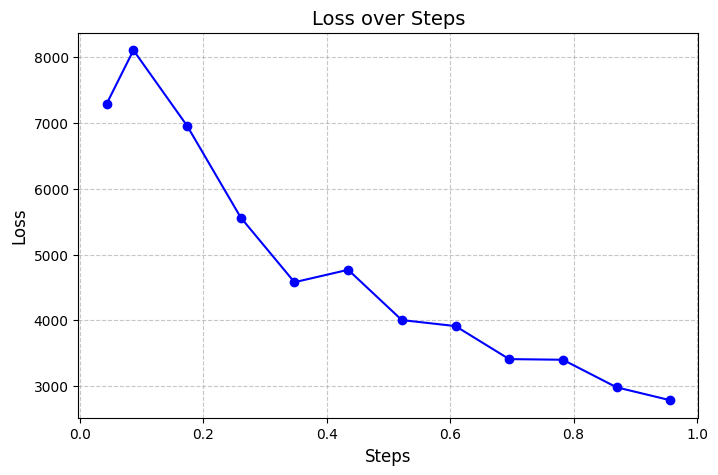

In [28]:
import matplotlib.pyplot as plt

# Assuming metricsdf already exists and has 'epoch' and 'eval_loss' columns

# Plot eval_loss over epochs
plt.figure(figsize=(8, 5))
plt.plot(metrics_df["epoch"], metrics_df["loss"], marker="o", linestyle="-", color="b")
plt.title("Loss over Steps", fontsize=14)
plt.xlabel("Steps", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

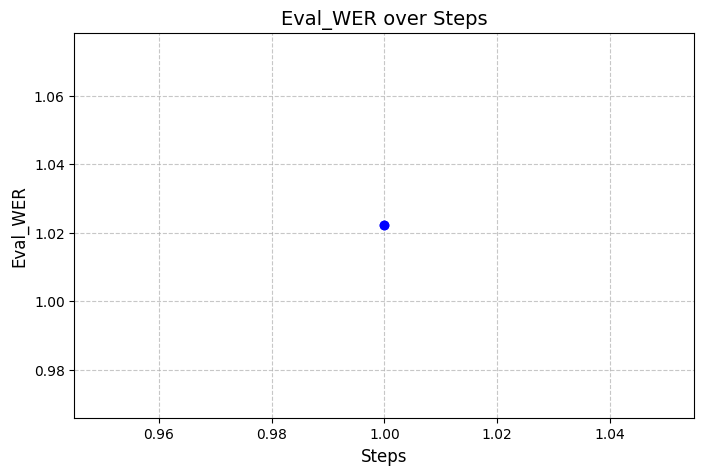

In [29]:
plt.figure(figsize=(8, 5))
plt.plot(metrics_df["epoch"], metrics_df["eval_wer"], marker="o", linestyle="-", color="b")
plt.title("Eval_WER over Steps", fontsize=14)
plt.xlabel("Steps", fontsize=12)
plt.ylabel("Eval_WER", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

I trained a few versions of the model with different hyperparameters, the best so far is saved under /Users/allen/Documents/Wav2vec_Project/asr-train/wav2vec2-large-960h-cv-backup

Compare with cv-valid-test

In [ ]:
from tqdm import tqdm
from jiwer import wer
from datasets import Dataset

cv_valid_test_directory = '/Users/allen/Documents/Wav2vec_Project/asr/common_voice/cv-valid-test/cv-valid-test'
cv_valid_test_csv = '/Users/allen/Documents/Wav2vec_Project/asr/common_voice/cv-valid-test.csv'
finetuned_model = AutoModelForCTC.from_pretrained("./wav2vec2-large-960h-cv-backup")
cv_valid_test_df = pd.read_csv(cv_valid_test_csv)
cv_valid_test_df = cv_valid_test_df.sample(frac=0.1, random_state=42)
ground_truth = {row['filename']: row['text'] for _, row in cv_valid_test_df.iterrows()}
mp3_files = [f for f in os.listdir(cv_valid_test_directory) if f.endswith('.mp3')]
wer_scores = []

# print (cv_valid_test_df)
# print (ground_truth)

for filepath in tqdm(cv_valid_test_df['filename'], desc="Processing MP3 files"):
    # print (filepath)
    # Load the MP3 file using pydub
    mp3_path = '/Users/allen/Documents/Wav2vec_Project/asr/common_voice/cv-valid-test/'+filepath
    # print (mp3_path)
    audio = AudioSegment.from_mp3(mp3_path)
    
    audio = audio.set_frame_rate(16000).set_channels(1)

    # print("Audio converted")
    
    # Load audio data from file into a format compatible with datasets
    audio_data = np.array(audio.get_array_of_samples(), dtype=np.float32)  # Ensure float32 type

    # Create a dataset from the audio data
    ds = Dataset.from_dict({
        "audio": [{"array": audio_data, "sampling_rate": 16000}]
    })

    # Tokenize input
    input_values = processor(ds[0]["audio"]["array"], return_tensors="pt", padding="longest", sampling_rate=16000).input_values  # Batch size 1
    
    # Make the prediction
    with torch.no_grad():
        logits = finetuned_model(input_values).logits
    
    # Decode the logits to text
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.decode(predicted_ids[0])
    # print (transcription)
    
    # Retrieve the ground truth transcription
    ground_truth_text = ground_truth.get(filepath, None)
    # print (ground_truth_text)
    
    # Calculate WER if ground truth is available
    if ground_truth_text:
        score = wer(str(ground_truth_text).lower(), str(transcription).lower())
        print ("score:", score)
        wer_scores.append(score)

# Calculate the average WER
average_wer = sum(wer_scores) / len(wer_scores) if wer_scores else 0

# # Print the average WER
# print(f"Average WER: {average_wer:.4f}")

Processing MP3 files:   0%|          | 0/400 [00:00<?, ?it/s]Python(90240) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90241) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   0%|          | 1/400 [00:00<05:26,  1.22it/s]

score: 0.15384615384615385


Python(90242) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90243) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   0%|          | 2/400 [00:01<03:30,  1.89it/s]

score: 0.125


Python(90244) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90245) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   1%|          | 3/400 [00:01<03:26,  1.92it/s]

score: 0.07692307692307693


Python(90246) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90247) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   1%|          | 4/400 [00:01<02:50,  2.33it/s]

score: 0.0


Python(90248) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90249) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   1%|▏         | 5/400 [00:02<02:41,  2.45it/s]

score: 0.5


Python(90250) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90251) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   2%|▏         | 6/400 [00:02<02:20,  2.81it/s]

score: 0.5


Python(90252) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90253) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   2%|▏         | 7/400 [00:02<02:19,  2.82it/s]

score: 0.1


Python(90254) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90255) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   2%|▏         | 8/400 [00:03<02:08,  3.06it/s]

score: 0.0


Python(90256) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90257) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   2%|▏         | 9/400 [00:03<02:01,  3.21it/s]

score: 1.0


Python(90258) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90259) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   2%|▎         | 10/400 [00:03<01:57,  3.31it/s]

score: 0.2


Python(90260) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90261) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   3%|▎         | 11/400 [00:04<02:00,  3.23it/s]

score: 0.5714285714285714


Python(90262) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90263) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   3%|▎         | 12/400 [00:04<02:09,  3.00it/s]

score: 0.0


Python(90264) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90265) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   3%|▎         | 13/400 [00:04<02:05,  3.09it/s]

score: 0.0


Python(90266) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90267) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   4%|▎         | 14/400 [00:05<02:16,  2.82it/s]

score: 0.2857142857142857


Python(90268) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90269) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   4%|▍         | 15/400 [00:05<02:17,  2.80it/s]

score: 0.5714285714285714


Python(90270) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90271) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   4%|▍         | 16/400 [00:05<02:10,  2.94it/s]

score: 0.3333333333333333


Python(90272) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90273) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   4%|▍         | 17/400 [00:06<02:06,  3.03it/s]

score: 0.2


Python(90274) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90275) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   4%|▍         | 18/400 [00:06<02:15,  2.82it/s]

score: 0.0


Python(90276) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90277) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   5%|▍         | 19/400 [00:07<02:29,  2.56it/s]

score: 0.5833333333333334


Python(90278) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90279) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   5%|▌         | 20/400 [00:07<02:14,  2.82it/s]

score: 0.25


Python(90280) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90281) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   5%|▌         | 21/400 [00:07<02:05,  3.02it/s]

score: 0.5


Python(90282) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90283) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   6%|▌         | 22/400 [00:07<02:12,  2.85it/s]

score: 0.18181818181818182


Python(90284) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90285) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   6%|▌         | 23/400 [00:08<02:09,  2.92it/s]

score: 0.0


Python(90286) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90287) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   6%|▌         | 24/400 [00:08<02:04,  3.03it/s]

score: 0.0


Python(90288) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90289) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   6%|▋         | 25/400 [00:08<01:59,  3.13it/s]

score: 0.0


Python(90290) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90291) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   6%|▋         | 26/400 [00:09<01:58,  3.14it/s]

score: 0.9166666666666666


Python(90292) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90293) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   7%|▋         | 27/400 [00:09<02:11,  2.84it/s]

score: 0.18181818181818182


Python(90294) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90295) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   7%|▋         | 28/400 [00:10<02:13,  2.78it/s]

score: 0.14285714285714285


Python(90296) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90297) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   7%|▋         | 29/400 [00:10<02:28,  2.49it/s]

score: 0.2777777777777778


Python(90298) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90299) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   8%|▊         | 30/400 [00:10<02:24,  2.56it/s]

score: 0.8571428571428571


Python(90300) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90301) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   8%|▊         | 31/400 [00:11<02:17,  2.68it/s]

score: 0.6


Python(90302) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90303) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   8%|▊         | 32/400 [00:11<02:17,  2.68it/s]

score: 0.08333333333333333


Python(90304) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90305) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   8%|▊         | 33/400 [00:11<02:12,  2.76it/s]

score: 0.23076923076923078


Python(90306) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90307) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   8%|▊         | 34/400 [00:12<02:05,  2.92it/s]

score: 0.16666666666666666


Python(90308) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90309) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   9%|▉         | 35/400 [00:12<01:59,  3.06it/s]

score: 0.14285714285714285


Python(90310) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90311) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   9%|▉         | 36/400 [00:12<02:05,  2.89it/s]

score: 0.07142857142857142


Python(90312) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90313) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   9%|▉         | 37/400 [00:13<02:02,  2.97it/s]

score: 0.8333333333333334


Python(90314) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90315) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  10%|▉         | 38/400 [00:13<02:10,  2.78it/s]

score: 0.2857142857142857


Python(90316) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90317) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  10%|▉         | 39/400 [00:13<02:03,  2.92it/s]

score: 0.375


Python(90318) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90319) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  10%|█         | 40/400 [00:14<02:00,  2.99it/s]

score: 0.2


Python(90320) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90321) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  10%|█         | 41/400 [00:14<02:01,  2.96it/s]

score: 0.2


Python(90322) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90323) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  10%|█         | 42/400 [00:14<01:53,  3.16it/s]

score: 0.42857142857142855


Python(90324) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90325) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  11%|█         | 43/400 [00:15<01:56,  3.06it/s]

score: 0.3333333333333333


Python(90326) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90327) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  11%|█         | 44/400 [00:15<01:49,  3.24it/s]

score: 0.5


Python(90328) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90329) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  11%|█▏        | 45/400 [00:15<02:05,  2.82it/s]

score: 0.3333333333333333


Python(90331) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90332) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  12%|█▏        | 46/400 [00:16<02:02,  2.89it/s]

score: 0.09090909090909091


Python(90333) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90334) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  12%|█▏        | 47/400 [00:16<02:29,  2.37it/s]

score: 0.13333333333333333


Python(90335) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90336) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  12%|█▏        | 48/400 [00:17<02:31,  2.33it/s]

score: 0.26666666666666666


Python(90337) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90338) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  12%|█▏        | 49/400 [00:17<02:21,  2.49it/s]

score: 0.15384615384615385


Python(90339) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90340) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  12%|█▎        | 50/400 [00:17<02:07,  2.74it/s]

score: 0.5


Python(90341) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90342) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  13%|█▎        | 51/400 [00:18<02:00,  2.90it/s]

score: 0.07692307692307693


Python(90343) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90344) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  13%|█▎        | 52/400 [00:18<01:50,  3.15it/s]

score: 0.75


Python(90345) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90346) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  13%|█▎        | 53/400 [00:18<01:51,  3.12it/s]

score: 0.25


Python(90347) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90348) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  14%|█▎        | 54/400 [00:19<01:44,  3.30it/s]

score: 1.0


Python(90349) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90350) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  14%|█▍        | 55/400 [00:19<01:50,  3.13it/s]

score: 0.08333333333333333


Python(90351) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90352) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  14%|█▍        | 56/400 [00:19<01:53,  3.03it/s]

score: 0.07142857142857142


Python(90353) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90354) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  14%|█▍        | 57/400 [00:20<01:54,  3.01it/s]

score: 0.08333333333333333


Python(90355) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90356) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  14%|█▍        | 58/400 [00:20<01:44,  3.26it/s]

score: 1.0


Python(90357) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90358) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  15%|█▍        | 59/400 [00:20<01:54,  2.98it/s]

score: 0.0


Python(90359) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90360) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  15%|█▌        | 60/400 [00:21<01:47,  3.18it/s]

score: 0.25


Python(90361) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90362) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  15%|█▌        | 61/400 [00:21<01:45,  3.20it/s]

score: 0.25


Python(90363) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90364) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  16%|█▌        | 62/400 [00:21<01:50,  3.05it/s]

score: 0.7142857142857143


Python(90365) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90366) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  16%|█▌        | 63/400 [00:21<01:45,  3.20it/s]

score: 0.25


Python(90367) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90368) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  16%|█▌        | 64/400 [00:22<01:45,  3.17it/s]

score: 0.09090909090909091


Python(90369) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90370) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  16%|█▋        | 65/400 [00:22<01:41,  3.30it/s]

score: 0.16666666666666666


Python(90371) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90372) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  16%|█▋        | 66/400 [00:22<01:44,  3.20it/s]

score: 0.3076923076923077


Python(90373) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90374) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  17%|█▋        | 67/400 [00:23<01:44,  3.18it/s]

score: 0.0


Python(90375) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90376) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  17%|█▋        | 68/400 [00:23<01:52,  2.96it/s]

score: 0.26666666666666666


Python(90377) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90378) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  17%|█▋        | 69/400 [00:23<01:52,  2.93it/s]

score: 0.3


Python(90379) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90380) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  18%|█▊        | 70/400 [00:24<01:58,  2.78it/s]

score: 0.15384615384615385


Python(90381) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90382) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  18%|█▊        | 71/400 [00:24<01:52,  2.93it/s]

score: 0.14285714285714285


Python(90384) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90385) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  18%|█▊        | 72/400 [00:24<01:47,  3.05it/s]

score: 1.0


Python(90386) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90387) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  18%|█▊        | 73/400 [00:25<01:47,  3.04it/s]

score: 0.09090909090909091


Python(90388) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90389) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  18%|█▊        | 74/400 [00:25<01:44,  3.13it/s]

score: 0.5714285714285714


Python(90390) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90392) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  19%|█▉        | 75/400 [00:26<02:12,  2.45it/s]

score: 0.5714285714285714


Python(90393) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90394) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  19%|█▉        | 76/400 [00:26<02:12,  2.45it/s]

score: 0.0


Python(90395) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90396) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  19%|█▉        | 77/400 [00:26<02:07,  2.54it/s]

score: 0.058823529411764705


Python(90397) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90398) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  20%|█▉        | 78/400 [00:27<02:13,  2.42it/s]

score: 0.7142857142857143


Python(90399) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90400) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  20%|█▉        | 79/400 [00:27<02:03,  2.59it/s]

score: 0.8333333333333334


Python(90401) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90402) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  20%|██        | 80/400 [00:28<02:13,  2.39it/s]

score: 0.2


Python(90404) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90405) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  20%|██        | 81/400 [00:28<02:02,  2.60it/s]

score: 0.0


Python(90406) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90407) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  20%|██        | 82/400 [00:28<01:54,  2.79it/s]

score: 0.0


Python(90408) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90409) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  21%|██        | 83/400 [00:29<01:50,  2.87it/s]

score: 0.0


Python(90410) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90411) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  21%|██        | 84/400 [00:29<01:42,  3.09it/s]

score: 0.0


Python(90412) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90415) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  21%|██▏       | 85/400 [00:29<01:35,  3.30it/s]

score: 0.25


Python(90416) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90417) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  22%|██▏       | 86/400 [00:30<01:44,  3.01it/s]

score: 0.0625


Python(90418) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90419) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  22%|██▏       | 87/400 [00:30<01:53,  2.76it/s]

score: 0.3076923076923077


Python(90420) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90421) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  22%|██▏       | 88/400 [00:30<01:54,  2.72it/s]

score: 0.2


Python(90424) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90425) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  22%|██▏       | 89/400 [00:31<01:52,  2.76it/s]

score: 0.15384615384615385


Python(90427) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90428) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  22%|██▎       | 90/400 [00:31<01:52,  2.76it/s]

score: 0.14285714285714285


Python(90429) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90430) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  23%|██▎       | 91/400 [00:32<01:54,  2.69it/s]

score: 0.26666666666666666


Python(90432) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90433) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  23%|██▎       | 92/400 [00:32<01:47,  2.85it/s]

score: 0.25


Python(90434) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90435) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  23%|██▎       | 93/400 [00:32<01:39,  3.09it/s]

score: 0.0


Python(90436) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90437) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  24%|██▎       | 94/400 [00:32<01:37,  3.14it/s]

score: 0.5714285714285714


Python(90438) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90439) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  24%|██▍       | 95/400 [00:33<01:36,  3.15it/s]

score: 0.18181818181818182


Python(90440) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90441) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  24%|██▍       | 96/400 [00:33<01:41,  3.00it/s]

score: 0.1875


Python(90442) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90443) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  24%|██▍       | 97/400 [00:33<01:42,  2.96it/s]

score: 0.23076923076923078


Python(90444) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90445) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  24%|██▍       | 98/400 [00:34<01:41,  2.98it/s]

score: 0.09090909090909091


Python(90446) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90447) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  25%|██▍       | 99/400 [00:34<01:32,  3.26it/s]

score: 0.0


Python(90448) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90449) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  25%|██▌       | 100/400 [00:34<01:35,  3.13it/s]

score: 0.1111111111111111


Python(90450) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90451) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  25%|██▌       | 101/400 [00:35<01:36,  3.10it/s]

score: 0.21428571428571427


Python(90452) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90453) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  26%|██▌       | 102/400 [00:35<01:32,  3.23it/s]

score: 0.5


Python(90454) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90455) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  26%|██▌       | 103/400 [00:35<01:31,  3.24it/s]

score: 0.5555555555555556


Python(90456) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90457) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  26%|██▌       | 104/400 [00:36<01:26,  3.42it/s]

score: 0.2


Python(90458) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90459) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  26%|██▋       | 105/400 [00:36<01:23,  3.53it/s]

score: 0.25


Python(90460) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90461) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  26%|██▋       | 106/400 [00:36<01:25,  3.42it/s]

score: 0.23076923076923078


Python(90462) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90463) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  27%|██▋       | 107/400 [00:37<01:36,  3.05it/s]

score: 0.0625


Python(90464) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90465) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  27%|██▋       | 108/400 [00:37<01:59,  2.44it/s]

score: 0.14285714285714285


Python(90466) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90467) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  27%|██▋       | 109/400 [00:37<01:56,  2.50it/s]

score: 0.3


Python(90468) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90469) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  28%|██▊       | 110/400 [00:38<01:45,  2.74it/s]

score: 0.14285714285714285


Python(90470) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90471) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  28%|██▊       | 111/400 [00:38<01:42,  2.81it/s]

score: 0.14285714285714285


Python(90474) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90475) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  28%|██▊       | 112/400 [00:38<01:36,  2.98it/s]

score: 0.08333333333333333


Python(90476) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90477) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  28%|██▊       | 113/400 [00:39<01:25,  3.34it/s]

score: 0.0


Python(90478) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90479) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  28%|██▊       | 114/400 [00:39<01:24,  3.39it/s]

score: 0.8888888888888888


Python(90480) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90481) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  29%|██▉       | 115/400 [00:39<01:29,  3.19it/s]

score: 0.4


Python(90482) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90483) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  29%|██▉       | 116/400 [00:40<01:30,  3.13it/s]

score: 0.0


Python(90484) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90485) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  29%|██▉       | 117/400 [00:40<01:28,  3.20it/s]

score: 0.2857142857142857


Python(90486) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90487) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  30%|██▉       | 118/400 [00:40<01:25,  3.30it/s]

score: 1.0


Python(90488) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90489) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  30%|██▉       | 119/400 [00:40<01:21,  3.45it/s]

score: 0.2


Python(90490) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90491) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  30%|███       | 120/400 [00:41<01:33,  3.00it/s]

score: 0.0


Python(90492) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90493) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  30%|███       | 121/400 [00:41<01:29,  3.11it/s]

score: 0.16666666666666666


Python(90494) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90495) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  30%|███       | 122/400 [00:41<01:30,  3.07it/s]

score: 0.16666666666666666


Python(90496) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90497) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  31%|███       | 123/400 [00:42<01:26,  3.19it/s]

score: 0.625


Python(90498) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90499) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  31%|███       | 124/400 [00:42<01:22,  3.34it/s]

score: 0.16666666666666666


Python(90500) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90501) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  31%|███▏      | 125/400 [00:43<02:30,  1.83it/s]

score: 0.3125


Python(90502) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90503) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  32%|███▏      | 126/400 [00:43<02:08,  2.13it/s]

score: 0.8571428571428571


Python(90504) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90505) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  32%|███▏      | 127/400 [00:44<02:08,  2.13it/s]

score: 0.0


Python(90506) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90507) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  32%|███▏      | 128/400 [00:44<01:50,  2.45it/s]

score: 0.16666666666666666


Python(90508) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90509) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  32%|███▏      | 129/400 [00:45<01:54,  2.36it/s]

score: 0.0


Python(90510) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90511) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  32%|███▎      | 130/400 [00:45<01:50,  2.45it/s]

score: 0.6


Python(90512) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90513) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  33%|███▎      | 131/400 [00:45<01:41,  2.65it/s]

score: 0.0


Python(90514) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90515) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  33%|███▎      | 132/400 [00:46<01:30,  2.95it/s]

score: 1.0


Python(90516) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90517) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  33%|███▎      | 133/400 [00:46<01:32,  2.89it/s]

score: 0.2


Python(90518) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90519) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  34%|███▎      | 134/400 [00:46<01:33,  2.84it/s]

score: 0.5454545454545454


Python(90520) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90521) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  34%|███▍      | 135/400 [00:47<02:02,  2.16it/s]

score: 0.7857142857142857


Python(90522) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90523) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  34%|███▍      | 136/400 [00:47<01:51,  2.37it/s]

score: 0.4


Python(90524) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90525) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  34%|███▍      | 137/400 [00:48<01:43,  2.53it/s]

score: 0.625


Python(90526) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90527) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  34%|███▍      | 138/400 [00:48<01:39,  2.62it/s]

score: 0.35294117647058826


Python(90528) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90529) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  35%|███▍      | 139/400 [00:48<01:31,  2.86it/s]

score: 0.1111111111111111


Python(90530) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90531) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  35%|███▌      | 140/400 [00:49<01:23,  3.11it/s]

score: 0.8


Python(90532) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90533) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  35%|███▌      | 141/400 [00:49<01:23,  3.10it/s]

score: 0.0


Python(90534) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90535) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  36%|███▌      | 142/400 [00:49<01:26,  3.00it/s]

score: 0.0


Python(90536) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90537) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  36%|███▌      | 143/400 [00:50<01:24,  3.03it/s]

score: 0.9230769230769231


Python(90538) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90539) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  36%|███▌      | 144/400 [00:50<01:20,  3.19it/s]

score: 0.6


Python(90540) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90541) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  36%|███▋      | 145/400 [00:50<01:22,  3.08it/s]

score: 0.4166666666666667


Python(90542) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90543) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  36%|███▋      | 146/400 [00:51<01:24,  3.01it/s]

score: 0.2727272727272727


Python(90544) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90545) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  37%|███▋      | 147/400 [00:51<01:18,  3.24it/s]

score: 0.0


Python(90546) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90547) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  37%|███▋      | 148/400 [00:51<01:20,  3.12it/s]

score: 0.1111111111111111


Python(90548) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90549) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  37%|███▋      | 149/400 [00:51<01:18,  3.20it/s]

score: 0.4444444444444444


Python(90550) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90551) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  38%|███▊      | 150/400 [00:52<01:15,  3.31it/s]

score: 0.3333333333333333


Python(90552) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90553) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  38%|███▊      | 151/400 [00:52<01:32,  2.71it/s]

score: 0.2


Python(90554) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90555) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  38%|███▊      | 152/400 [00:53<01:27,  2.83it/s]

score: 0.75


Python(90556) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90558) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  38%|███▊      | 153/400 [00:53<01:23,  2.96it/s]

score: 0.75


Python(90559) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90560) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  38%|███▊      | 154/400 [00:53<01:29,  2.73it/s]

score: 0.0


Python(90561) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90562) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  39%|███▉      | 155/400 [00:54<01:27,  2.80it/s]

score: 0.09090909090909091


Python(90563) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90564) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  39%|███▉      | 156/400 [00:54<01:26,  2.83it/s]

score: 0.0


Python(90565) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90566) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  39%|███▉      | 157/400 [00:54<01:16,  3.18it/s]

score: 1.0


Python(90567) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90569) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  40%|███▉      | 158/400 [00:55<01:29,  2.72it/s]

score: 0.1875


Python(90570) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90571) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  40%|███▉      | 159/400 [00:55<01:29,  2.69it/s]

score: 0.23076923076923078


Python(90572) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90573) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  40%|████      | 160/400 [00:55<01:25,  2.80it/s]

score: 0.125


Python(90575) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90577) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  40%|████      | 161/400 [00:56<01:24,  2.83it/s]

score: 0.4444444444444444


Python(90578) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90579) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  40%|████      | 162/400 [00:56<01:32,  2.56it/s]

score: 0.0


Python(90580) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90581) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  41%|████      | 163/400 [00:57<01:28,  2.66it/s]

score: 0.16666666666666666


Python(90583) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90584) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  41%|████      | 164/400 [00:57<01:33,  2.52it/s]

score: 0.1875


Python(90585) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90586) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  41%|████▏     | 165/400 [00:57<01:28,  2.66it/s]

score: 0.0


Python(90587) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90588) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  42%|████▏     | 166/400 [00:58<01:27,  2.68it/s]

score: 0.06666666666666667


Python(90589) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90590) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  42%|████▏     | 167/400 [00:58<01:18,  2.95it/s]

score: 1.0


Python(90591) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90592) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  42%|████▏     | 168/400 [00:58<01:17,  2.98it/s]

score: 0.1


Python(90593) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90594) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  42%|████▏     | 169/400 [00:59<01:12,  3.18it/s]

score: 0.0


Python(90595) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90596) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  42%|████▎     | 170/400 [00:59<01:10,  3.27it/s]

score: 0.25


Python(90597) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90598) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  43%|████▎     | 171/400 [00:59<01:13,  3.13it/s]

score: 0.7777777777777778


Python(90599) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90600) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  43%|████▎     | 172/400 [00:59<01:08,  3.33it/s]

score: 0.3333333333333333


Python(90601) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90602) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  43%|████▎     | 173/400 [01:00<01:08,  3.33it/s]

score: 0.46153846153846156


Python(90603) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90604) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  44%|████▎     | 174/400 [01:00<01:06,  3.41it/s]

score: 0.6666666666666666


Python(90606) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90609) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  44%|████▍     | 175/400 [01:00<01:06,  3.36it/s]

score: 0.16666666666666666


Python(90611) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90612) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  44%|████▍     | 176/400 [01:01<01:13,  3.03it/s]

score: 0.2857142857142857


Python(90613) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90614) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  44%|████▍     | 177/400 [01:01<01:15,  2.95it/s]

score: 0.3076923076923077


Python(90615) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90616) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  44%|████▍     | 178/400 [01:01<01:11,  3.09it/s]

score: 0.0


Python(90617) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90618) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  45%|████▍     | 179/400 [01:02<01:21,  2.72it/s]

score: 0.06666666666666667


Python(90619) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90620) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  45%|████▌     | 180/400 [01:02<01:18,  2.82it/s]

score: 0.15384615384615385


Python(90621) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90622) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  45%|████▌     | 181/400 [01:02<01:12,  3.02it/s]

score: 0.25


Python(90623) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90624) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  46%|████▌     | 182/400 [01:03<01:13,  2.96it/s]

score: 0.21428571428571427


Python(90625) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90626) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  46%|████▌     | 183/400 [01:03<01:19,  2.74it/s]

score: 0.36363636363636365


Python(90627) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90628) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  46%|████▌     | 184/400 [01:04<01:18,  2.75it/s]

score: 0.4


Python(90629) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90630) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  46%|████▋     | 185/400 [01:04<01:15,  2.83it/s]

score: 0.23076923076923078


Python(90631) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90632) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  46%|████▋     | 186/400 [01:04<01:16,  2.81it/s]

score: 0.3333333333333333


Python(90633) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90634) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  47%|████▋     | 187/400 [01:05<01:16,  2.77it/s]

score: 0.06666666666666667


Python(90635) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90636) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  47%|████▋     | 188/400 [01:05<01:16,  2.76it/s]

score: 0.21428571428571427


Python(90639) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90640) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  47%|████▋     | 189/400 [01:05<01:10,  2.99it/s]

score: 0.25


Python(90641) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90642) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  48%|████▊     | 190/400 [01:06<01:06,  3.17it/s]

score: 0.4


Python(90643) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90644) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  48%|████▊     | 191/400 [01:06<01:13,  2.85it/s]

score: 0.1875


Python(90645) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90646) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  48%|████▊     | 192/400 [01:06<01:08,  3.04it/s]

score: 0.2


Python(90648) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90649) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  48%|████▊     | 193/400 [01:07<01:20,  2.56it/s]

score: 0.375


Python(90650) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90651) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  48%|████▊     | 194/400 [01:07<01:16,  2.69it/s]

score: 0.25


Python(90652) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90653) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  49%|████▉     | 195/400 [01:08<01:17,  2.65it/s]

score: 0.25


Python(90654) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90655) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  49%|████▉     | 196/400 [01:08<01:11,  2.84it/s]

score: 0.25


Python(90656) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90657) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  49%|████▉     | 197/400 [01:08<01:07,  3.01it/s]

score: 0.2857142857142857


Python(90658) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90659) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  50%|████▉     | 198/400 [01:08<01:05,  3.06it/s]

score: 0.16666666666666666


Python(90661) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90662) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  50%|████▉     | 199/400 [01:09<01:14,  2.70it/s]

score: 0.5


Python(90663) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90664) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  50%|█████     | 200/400 [01:09<01:07,  2.98it/s]

score: 0.2


Python(90665) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90666) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  50%|█████     | 201/400 [01:10<01:11,  2.77it/s]

score: 0.0


Python(90667) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90668) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  50%|█████     | 202/400 [01:10<01:14,  2.67it/s]

score: 0.5


Python(90669) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90670) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  51%|█████     | 203/400 [01:10<01:16,  2.58it/s]

score: 0.5


Python(90671) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90672) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  51%|█████     | 204/400 [01:11<01:10,  2.79it/s]

score: 0.0


Python(90673) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90674) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  51%|█████▏    | 205/400 [01:11<01:09,  2.81it/s]

score: 0.09090909090909091


Python(90675) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90676) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  52%|█████▏    | 206/400 [01:11<01:03,  3.07it/s]

score: 0.2


Python(90677) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90678) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  52%|█████▏    | 207/400 [01:12<01:02,  3.10it/s]

score: 0.1111111111111111


Python(90679) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90680) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  52%|█████▏    | 208/400 [01:12<01:04,  2.97it/s]

score: 0.7


Python(90681) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90682) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  52%|█████▏    | 209/400 [01:12<01:01,  3.09it/s]

score: 0.25


Python(90683) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90684) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  52%|█████▎    | 210/400 [01:13<01:05,  2.90it/s]

score: 0.3333333333333333


Python(90685) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90686) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  53%|█████▎    | 211/400 [01:13<01:01,  3.06it/s]

score: 0.6666666666666666


Python(90687) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90688) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  53%|█████▎    | 212/400 [01:13<00:58,  3.23it/s]

score: 0.3333333333333333


Python(90689) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90690) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  53%|█████▎    | 213/400 [01:13<00:56,  3.31it/s]

score: 0.16666666666666666


Python(90691) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90692) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  54%|█████▎    | 214/400 [01:14<00:57,  3.21it/s]

score: 0.2


Python(90693) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90694) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  54%|█████▍    | 215/400 [01:14<01:02,  2.96it/s]

score: 0.0


Python(90695) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90696) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  54%|█████▍    | 216/400 [01:15<01:02,  2.95it/s]

score: 0.1


Python(90697) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90698) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  54%|█████▍    | 217/400 [01:15<01:02,  2.91it/s]

score: 0.5


Python(90699) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90700) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  55%|█████▍    | 218/400 [01:15<00:59,  3.05it/s]

score: 0.18181818181818182


Python(90701) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90702) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  55%|█████▍    | 219/400 [01:16<01:02,  2.92it/s]

score: 0.25


Python(90703) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90704) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  55%|█████▌    | 220/400 [01:16<01:01,  2.93it/s]

score: 0.09090909090909091


Python(90705) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90706) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  55%|█████▌    | 221/400 [01:16<01:03,  2.82it/s]

score: 0.75


Python(90707) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90708) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  56%|█████▌    | 222/400 [01:17<01:00,  2.94it/s]

score: 0.5714285714285714


Python(90709) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90710) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  56%|█████▌    | 223/400 [01:17<01:01,  2.87it/s]

score: 0.4


Python(90711) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90712) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  56%|█████▌    | 224/400 [01:17<00:57,  3.04it/s]

score: 0.2


Python(90713) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90714) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  56%|█████▋    | 225/400 [01:18<01:00,  2.91it/s]

score: 0.2857142857142857


Python(90715) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90716) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  56%|█████▋    | 226/400 [01:18<00:57,  3.05it/s]

score: 0.2222222222222222


Python(90717) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90718) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  57%|█████▋    | 227/400 [01:18<00:56,  3.04it/s]

score: 0.3333333333333333


Python(90719) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90720) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  57%|█████▋    | 228/400 [01:19<00:53,  3.20it/s]

score: 0.2222222222222222


Python(90721) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90722) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  57%|█████▋    | 229/400 [01:19<00:57,  3.00it/s]

score: 0.16666666666666666


Python(90723) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90724) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  57%|█████▊    | 230/400 [01:19<00:55,  3.05it/s]

score: 0.125


Python(90725) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90726) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  58%|█████▊    | 231/400 [01:20<00:55,  3.06it/s]

score: 0.23076923076923078


Python(90727) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90728) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  58%|█████▊    | 232/400 [01:20<00:52,  3.23it/s]

score: 0.125


Python(90729) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90730) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  58%|█████▊    | 233/400 [01:20<00:52,  3.18it/s]

score: 0.1111111111111111


Python(90731) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90732) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  58%|█████▊    | 234/400 [01:21<00:58,  2.85it/s]

score: 0.2


Python(90733) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90734) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  59%|█████▉    | 235/400 [01:21<00:58,  2.84it/s]

score: 0.3333333333333333


Python(90735) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90736) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  59%|█████▉    | 236/400 [01:21<00:52,  3.14it/s]

score: 0.75


Python(90737) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90738) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  59%|█████▉    | 237/400 [01:22<00:52,  3.10it/s]

score: 0.09090909090909091


Python(90739) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90740) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  60%|█████▉    | 238/400 [01:22<00:56,  2.88it/s]

score: 0.3125


Python(90741) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90742) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  60%|█████▉    | 239/400 [01:22<00:56,  2.84it/s]

score: 0.2


Python(90743) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90744) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  60%|██████    | 240/400 [01:23<00:52,  3.05it/s]

score: 0.0


Python(90745) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90746) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  60%|██████    | 241/400 [01:23<00:52,  3.04it/s]

score: 0.0


Python(90747) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90748) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  60%|██████    | 242/400 [01:23<00:50,  3.11it/s]

score: 0.08333333333333333


Python(90749) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90750) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  61%|██████    | 243/400 [01:23<00:49,  3.20it/s]

score: 0.14285714285714285


Python(90751) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90752) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  61%|██████    | 244/400 [01:24<00:50,  3.10it/s]

score: 0.1


Python(90753) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90754) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  61%|██████▏   | 245/400 [01:24<00:46,  3.32it/s]

score: 0.5


Python(90755) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90756) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  62%|██████▏   | 246/400 [01:24<00:49,  3.14it/s]

score: 0.21428571428571427


Python(90757) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90758) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  62%|██████▏   | 247/400 [01:25<00:52,  2.92it/s]

score: 0.0


Python(90759) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90760) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  62%|██████▏   | 248/400 [01:26<01:30,  1.67it/s]

score: 0.0


Python(90761) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90762) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  62%|██████▏   | 249/400 [01:26<01:16,  1.98it/s]

score: 0.0


Python(90763) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90764) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  62%|██████▎   | 250/400 [01:27<01:06,  2.24it/s]

score: 0.25


Python(90765) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90766) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  63%|██████▎   | 251/400 [01:27<01:08,  2.19it/s]

score: 0.6428571428571429


Python(90767) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90768) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  63%|██████▎   | 252/400 [01:27<01:01,  2.40it/s]

score: 0.0


Python(90769) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90770) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  63%|██████▎   | 253/400 [01:28<00:58,  2.53it/s]

score: 0.18181818181818182


Python(90771) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90772) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  64%|██████▎   | 254/400 [01:28<00:55,  2.65it/s]

score: 0.375


Python(90773) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90774) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  64%|██████▍   | 255/400 [01:29<00:54,  2.66it/s]

score: 0.09090909090909091


Python(90775) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90776) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  64%|██████▍   | 256/400 [01:29<00:53,  2.71it/s]

score: 0.1


Python(90777) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90778) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  64%|██████▍   | 257/400 [01:29<00:55,  2.58it/s]

score: 0.058823529411764705


Python(90779) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90780) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  64%|██████▍   | 258/400 [01:30<00:50,  2.80it/s]

score: 0.5


Python(90781) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90782) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  65%|██████▍   | 259/400 [01:30<00:52,  2.67it/s]

score: 0.36363636363636365


Python(90783) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90784) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  65%|██████▌   | 260/400 [01:30<00:49,  2.82it/s]

score: 0.125


Python(90785) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90786) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  65%|██████▌   | 261/400 [01:31<00:47,  2.95it/s]

score: 0.75


Python(90787) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90788) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  66%|██████▌   | 262/400 [01:31<00:43,  3.19it/s]

score: 0.5


Python(90789) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90790) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  66%|██████▌   | 263/400 [01:31<00:41,  3.30it/s]

score: 0.0


Python(90791) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90792) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  66%|██████▌   | 264/400 [01:31<00:42,  3.18it/s]

score: 0.36363636363636365


Python(90793) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90794) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  66%|██████▋   | 265/400 [01:32<00:42,  3.17it/s]

score: 0.2857142857142857


Python(90795) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90796) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  66%|██████▋   | 266/400 [01:32<00:46,  2.86it/s]

score: 0.07692307692307693


Python(90797) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90798) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  67%|██████▋   | 267/400 [01:33<00:46,  2.88it/s]

score: 0.2857142857142857


Python(90799) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90800) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  67%|██████▋   | 268/400 [01:33<00:47,  2.75it/s]

score: 0.2222222222222222


Python(90801) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90802) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  67%|██████▋   | 269/400 [01:33<00:45,  2.86it/s]

score: 0.42857142857142855


Python(90803) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90804) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  68%|██████▊   | 270/400 [01:34<00:44,  2.90it/s]

score: 0.0


Python(90805) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90806) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  68%|██████▊   | 271/400 [01:34<00:43,  3.00it/s]

score: 0.6666666666666666


Python(90807) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90808) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  68%|██████▊   | 272/400 [01:34<00:43,  2.93it/s]

score: 0.3333333333333333


Python(90809) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90810) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  68%|██████▊   | 273/400 [01:35<00:43,  2.90it/s]

score: 0.2


Python(90811) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90812) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  68%|██████▊   | 274/400 [01:35<00:42,  2.96it/s]

score: 0.5


Python(90813) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90814) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  69%|██████▉   | 275/400 [01:35<00:42,  2.97it/s]

score: 0.5555555555555556


Python(90815) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90816) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  69%|██████▉   | 276/400 [01:36<00:42,  2.89it/s]

score: 0.16666666666666666


Python(90817) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90818) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  69%|██████▉   | 277/400 [01:36<00:41,  2.98it/s]

score: 0.2


Python(90819) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90820) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  70%|██████▉   | 278/400 [01:37<00:48,  2.49it/s]

score: 0.125


Python(90821) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90822) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  70%|██████▉   | 279/400 [01:37<00:47,  2.57it/s]

score: 0.25


Python(90823) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90824) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  70%|███████   | 280/400 [01:37<00:43,  2.75it/s]

score: 0.14285714285714285


Python(90825) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90826) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  70%|███████   | 281/400 [01:38<00:43,  2.73it/s]

score: 0.0


Python(90827) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90828) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  70%|███████   | 282/400 [01:38<00:44,  2.64it/s]

score: 0.3076923076923077


Python(90829) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90830) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  71%|███████   | 283/400 [01:38<00:43,  2.70it/s]

score: 0.5


Python(90831) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90832) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  71%|███████   | 284/400 [01:39<00:42,  2.72it/s]

score: 0.15384615384615385


Python(90834) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90835) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  71%|███████▏  | 285/400 [01:39<00:40,  2.87it/s]

score: 0.6666666666666666


Python(90836) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90837) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  72%|███████▏  | 286/400 [01:39<00:39,  2.92it/s]

score: 0.0


Python(90838) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90839) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  72%|███████▏  | 287/400 [01:40<00:35,  3.17it/s]

score: 0.2


Python(90840) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90841) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  72%|███████▏  | 288/400 [01:40<00:42,  2.62it/s]

score: 0.14285714285714285


Python(90842) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90843) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  72%|███████▏  | 289/400 [01:40<00:42,  2.59it/s]

score: 0.14285714285714285


Python(90844) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90846) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  72%|███████▎  | 290/400 [01:41<00:41,  2.62it/s]

score: 0.38461538461538464


Python(90847) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90848) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  73%|███████▎  | 291/400 [01:41<00:40,  2.70it/s]

score: 0.0


Python(90849) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90850) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  73%|███████▎  | 292/400 [01:42<00:40,  2.69it/s]

score: 0.7857142857142857


Python(90851) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90852) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  73%|███████▎  | 293/400 [01:42<00:41,  2.55it/s]

score: 0.2727272727272727


Python(90853) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90854) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  74%|███████▎  | 294/400 [01:42<00:43,  2.45it/s]

score: 0.09090909090909091


Python(90855) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90856) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  74%|███████▍  | 295/400 [01:43<00:43,  2.43it/s]

score: 0.14285714285714285


Python(90857) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90858) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  74%|███████▍  | 296/400 [01:43<00:38,  2.73it/s]

score: 0.5


Python(90859) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90860) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  74%|███████▍  | 297/400 [01:44<00:39,  2.62it/s]

score: 0.25


Python(90861) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90862) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  74%|███████▍  | 298/400 [01:44<00:43,  2.35it/s]

score: 0.5384615384615384


Python(90863) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90864) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  75%|███████▍  | 299/400 [01:44<00:39,  2.55it/s]

score: 0.0


Python(90865) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90866) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  75%|███████▌  | 300/400 [01:45<00:41,  2.40it/s]

score: 0.5714285714285714


Python(90867) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90868) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  75%|███████▌  | 301/400 [01:45<00:37,  2.64it/s]

score: 0.75


Python(90869) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90870) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  76%|███████▌  | 302/400 [01:46<00:36,  2.67it/s]

score: 0.15384615384615385


Python(90871) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90872) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  76%|███████▌  | 303/400 [01:46<00:37,  2.58it/s]

score: 0.13333333333333333


Python(90873) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90874) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  76%|███████▌  | 304/400 [01:46<00:34,  2.77it/s]

score: 1.0


Python(90875) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90876) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  76%|███████▋  | 305/400 [01:47<00:36,  2.58it/s]

score: 0.09090909090909091


Python(90877) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90878) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  76%|███████▋  | 306/400 [01:47<00:35,  2.64it/s]

score: 0.3333333333333333


Python(90879) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90880) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  77%|███████▋  | 307/400 [01:47<00:35,  2.59it/s]

score: 0.09090909090909091


Python(90881) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90882) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  77%|███████▋  | 308/400 [01:48<00:32,  2.79it/s]

score: 0.0


Python(90883) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90884) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  77%|███████▋  | 309/400 [01:48<00:32,  2.77it/s]

score: 0.36363636363636365


Python(90885) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90886) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  78%|███████▊  | 310/400 [01:49<00:34,  2.64it/s]

score: 0.0


Python(90887) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90888) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  78%|███████▊  | 311/400 [01:49<00:32,  2.73it/s]

score: 0.0


Python(90889) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90890) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  78%|███████▊  | 312/400 [01:49<00:31,  2.80it/s]

score: 1.0


Python(90891) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90892) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  78%|███████▊  | 313/400 [01:50<00:29,  2.95it/s]

score: 0.3333333333333333


Python(90893) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90894) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  78%|███████▊  | 314/400 [01:50<00:31,  2.72it/s]

score: 0.3333333333333333


Python(90896) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90897) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  79%|███████▉  | 315/400 [01:50<00:30,  2.79it/s]

score: 0.5


Python(90898) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90899) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  79%|███████▉  | 316/400 [01:51<00:30,  2.75it/s]

score: 0.46153846153846156


Python(90900) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90901) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  79%|███████▉  | 317/400 [01:51<00:28,  2.92it/s]

score: 0.0


Python(90902) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90903) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  80%|███████▉  | 318/400 [01:51<00:30,  2.72it/s]

score: 0.09090909090909091


Python(90911) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90912) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  80%|███████▉  | 319/400 [01:52<00:28,  2.83it/s]

score: 0.7142857142857143


Python(90913) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90914) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  80%|████████  | 320/400 [01:52<00:27,  2.96it/s]

score: 0.75


Python(90915) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90916) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  80%|████████  | 321/400 [01:52<00:24,  3.17it/s]

score: 0.8


Python(90917) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90918) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  80%|████████  | 322/400 [01:53<00:26,  2.94it/s]

score: 0.1875


Python(90919) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90920) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  81%|████████  | 323/400 [01:53<00:25,  3.00it/s]

score: 0.6666666666666666


Python(90921) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90922) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  81%|████████  | 324/400 [01:53<00:24,  3.12it/s]

score: 0.5


Python(90923) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90924) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  81%|████████▏ | 325/400 [01:54<00:27,  2.72it/s]

score: 0.125


Python(90925) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90926) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  82%|████████▏ | 326/400 [01:54<00:25,  2.90it/s]

score: 0.0


Python(90927) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90928) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  82%|████████▏ | 327/400 [01:54<00:24,  2.96it/s]

score: 0.0


Python(90929) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90930) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  82%|████████▏ | 328/400 [01:55<00:25,  2.83it/s]

score: 0.0


Python(90931) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90932) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  82%|████████▏ | 329/400 [01:55<00:22,  3.13it/s]

score: 0.3333333333333333


Python(90933) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90934) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  82%|████████▎ | 330/400 [01:55<00:21,  3.20it/s]

score: 0.5


Python(90935) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90936) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  83%|████████▎ | 331/400 [01:56<00:21,  3.16it/s]

score: 0.09090909090909091


Python(90937) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90938) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  83%|████████▎ | 332/400 [01:56<00:22,  3.06it/s]

score: 0.25


Python(90939) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90940) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  83%|████████▎ | 333/400 [01:56<00:22,  2.98it/s]

score: 0.07692307692307693


Python(90941) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90942) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  84%|████████▎ | 334/400 [01:57<00:21,  3.13it/s]

score: 0.5


Python(90943) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90944) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  84%|████████▍ | 335/400 [01:57<00:20,  3.18it/s]

score: 0.09090909090909091


Python(90945) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90946) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  84%|████████▍ | 336/400 [01:57<00:19,  3.30it/s]

score: 1.0


Python(90948) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90949) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  84%|████████▍ | 337/400 [01:58<00:19,  3.22it/s]

score: 0.4


Python(90950) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90951) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  84%|████████▍ | 338/400 [01:58<00:20,  3.06it/s]

score: 0.0


Python(90952) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90953) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  85%|████████▍ | 339/400 [01:58<00:21,  2.85it/s]

score: 0.0


Python(90954) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90955) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  85%|████████▌ | 340/400 [01:59<00:19,  3.08it/s]

score: 0.0


Python(90956) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90957) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  85%|████████▌ | 341/400 [01:59<00:18,  3.15it/s]

score: 0.5714285714285714


Python(90958) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90959) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  86%|████████▌ | 342/400 [01:59<00:16,  3.44it/s]

score: 0.5


Python(90960) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90961) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  86%|████████▌ | 343/400 [01:59<00:17,  3.28it/s]

score: 1.0


Python(90962) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90963) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  86%|████████▌ | 344/400 [02:00<00:16,  3.34it/s]

score: 0.5714285714285714


Python(90964) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90965) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  86%|████████▋ | 345/400 [02:00<00:17,  3.12it/s]

score: 1.0


Python(90966) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90967) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  86%|████████▋ | 346/400 [02:00<00:17,  3.08it/s]

score: 0.0


Python(90968) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90969) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  87%|████████▋ | 347/400 [02:01<00:17,  3.03it/s]

score: 0.4444444444444444


Python(90970) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90971) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  87%|████████▋ | 348/400 [02:01<00:17,  3.02it/s]

score: 0.2222222222222222


Python(90972) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90973) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  87%|████████▋ | 349/400 [02:01<00:17,  2.95it/s]

score: 0.0


Python(90974) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90975) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  88%|████████▊ | 350/400 [02:02<00:20,  2.50it/s]

score: 0.125


Python(90976) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90978) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  88%|████████▊ | 351/400 [02:02<00:19,  2.56it/s]

score: 0.46153846153846156


Python(90979) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90981) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  88%|████████▊ | 352/400 [02:03<00:17,  2.67it/s]

score: 0.3125


Python(90982) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90983) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  88%|████████▊ | 353/400 [02:03<00:17,  2.73it/s]

score: 0.2222222222222222


Python(90984) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90985) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  88%|████████▊ | 354/400 [02:03<00:15,  2.98it/s]

score: 0.0


Python(90986) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90987) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  89%|████████▉ | 355/400 [02:04<00:14,  3.09it/s]

score: 0.5555555555555556


Python(90988) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90990) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  89%|████████▉ | 356/400 [02:04<00:14,  3.02it/s]

score: 0.26666666666666666


Python(90991) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90992) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  89%|████████▉ | 357/400 [02:04<00:13,  3.17it/s]

score: 0.6666666666666666


Python(90994) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90995) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  90%|████████▉ | 358/400 [02:05<00:12,  3.26it/s]

score: 0.1


Python(90996) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(90998) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  90%|████████▉ | 359/400 [02:05<00:12,  3.30it/s]

score: 0.0


Python(90999) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91000) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  90%|█████████ | 360/400 [02:05<00:11,  3.36it/s]

score: 0.3333333333333333


Python(91001) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91003) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  90%|█████████ | 361/400 [02:05<00:12,  3.08it/s]

score: 0.0


Python(91004) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91005) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  90%|█████████ | 362/400 [02:06<00:12,  3.06it/s]

score: 0.38461538461538464


Python(91006) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91007) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  91%|█████████ | 363/400 [02:06<00:12,  2.98it/s]

score: 0.0


Python(91008) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91009) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  91%|█████████ | 364/400 [02:06<00:11,  3.15it/s]

score: 0.16666666666666666


Python(91010) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91011) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  91%|█████████▏| 365/400 [02:07<00:11,  2.92it/s]

score: 0.42857142857142855


Python(91012) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91013) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  92%|█████████▏| 366/400 [02:07<00:11,  2.95it/s]

score: 0.1


Python(91014) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91015) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  92%|█████████▏| 367/400 [02:07<00:10,  3.08it/s]

score: 0.0


Python(91016) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91017) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  92%|█████████▏| 368/400 [02:08<00:11,  2.79it/s]

score: 0.15384615384615385


Python(91018) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91019) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  92%|█████████▏| 369/400 [02:08<00:10,  2.82it/s]

score: 0.25


Python(91020) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91021) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  92%|█████████▎| 370/400 [02:09<00:10,  2.99it/s]

score: 0.2


Python(91022) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91023) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  93%|█████████▎| 371/400 [02:09<00:09,  3.06it/s]

score: 0.25


Python(91024) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91025) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  93%|█████████▎| 372/400 [02:09<00:08,  3.15it/s]

score: 0.375


Python(91026) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91027) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  93%|█████████▎| 373/400 [02:09<00:08,  3.22it/s]

score: 0.4


Python(91028) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91029) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  94%|█████████▎| 374/400 [02:10<00:08,  3.12it/s]

score: 0.3076923076923077


Python(91034) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91035) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  94%|█████████▍| 375/400 [02:10<00:07,  3.32it/s]

score: 0.7777777777777778


Python(91037) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91038) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  94%|█████████▍| 376/400 [02:11<00:09,  2.48it/s]

score: 0.045454545454545456


Python(91042) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91043) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  94%|█████████▍| 377/400 [02:12<00:12,  1.78it/s]

score: 0.4375


Python(91049) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91050) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  94%|█████████▍| 378/400 [02:12<00:10,  2.00it/s]

score: 0.13333333333333333


Python(91051) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91052) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  95%|█████████▍| 379/400 [02:12<00:09,  2.33it/s]

score: 0.5


Python(91053) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91054) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  95%|█████████▌| 380/400 [02:13<00:07,  2.57it/s]

score: 0.5


Python(91055) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91056) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  95%|█████████▌| 381/400 [02:13<00:07,  2.61it/s]

score: 0.058823529411764705


Python(91057) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91058) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  96%|█████████▌| 382/400 [02:13<00:06,  2.74it/s]

score: 0.3333333333333333


Python(91059) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91060) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  96%|█████████▌| 383/400 [02:14<00:05,  2.92it/s]

score: 0.6


Python(91061) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91062) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  96%|█████████▌| 384/400 [02:14<00:04,  3.21it/s]

score: 0.5


Python(91063) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91064) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  96%|█████████▋| 385/400 [02:14<00:04,  3.25it/s]

score: 0.6


Python(91065) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91066) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  96%|█████████▋| 386/400 [02:14<00:03,  3.51it/s]

score: 0.2


Python(91067) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91068) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  97%|█████████▋| 387/400 [02:15<00:03,  3.42it/s]

score: 0.16666666666666666


Python(91069) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91070) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  97%|█████████▋| 388/400 [02:15<00:03,  3.41it/s]

score: 0.0


Python(91071) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91072) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  97%|█████████▋| 389/400 [02:15<00:02,  3.73it/s]

score: 0.5


Python(91073) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91074) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  98%|█████████▊| 390/400 [02:15<00:02,  3.72it/s]

score: 0.14285714285714285


Python(91075) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91076) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  98%|█████████▊| 391/400 [02:16<00:02,  3.78it/s]

score: 0.2


Python(91077) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91078) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  98%|█████████▊| 392/400 [02:16<00:02,  3.47it/s]

score: 0.15384615384615385


Python(91079) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91080) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  98%|█████████▊| 393/400 [02:16<00:01,  3.56it/s]

score: 0.4


Python(91081) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91082) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  98%|█████████▊| 394/400 [02:17<00:01,  3.53it/s]

score: 0.375


Python(91083) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91084) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  99%|█████████▉| 395/400 [02:17<00:01,  3.31it/s]

score: 0.07142857142857142


Python(91085) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91086) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  99%|█████████▉| 396/400 [02:17<00:01,  2.94it/s]

score: 0.375


Python(91087) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91088) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  99%|█████████▉| 397/400 [02:18<00:00,  3.15it/s]

score: 0.0


Python(91089) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91090) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files: 100%|█████████▉| 398/400 [02:18<00:00,  3.27it/s]

score: 0.9


Python(91091) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91092) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files: 100%|█████████▉| 399/400 [02:18<00:00,  3.35it/s]

score: 0.2


Python(91093) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(91094) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files: 100%|██████████| 400/400 [02:18<00:00,  2.88it/s]

score: 0.75


In [35]:
# Print the average WER
print(f"Average WER: {average_wer:.4f}")

Average WER: 0.2915


Question 4: Compare with Original Model for cv-valid-dev mp3 files.

In [41]:
cv_valid_dev_directory = '/Users/allen/Documents/Wav2vec_Project/asr/common_voice/cv-valid-dev/cv-valid-dev'
cv_valid_dev_csv = '/Users/allen/Documents/Wav2vec_Project/asr/common_voice/cv-valid-dev.csv'
finetuned_model = AutoModelForCTC.from_pretrained("./wav2vec2-large-960h-cv-backup")
original_model = model
cv_valid_dev_df = pd.read_csv(cv_valid_dev_csv)
cv_valid_dev_df = cv_valid_dev_df.sample(frac=0.1, random_state=42)
ground_truth = {row['filename']: row['text'] for _, row in cv_valid_dev_df.iterrows()}
mp3_files = [f for f in os.listdir(cv_valid_dev_directory) if f.endswith('.mp3')]
wer_scores_finetuned = []
wer_scores_original = []

# print (cv_valid_test_df)
# print (ground_truth)

for filepath in tqdm(cv_valid_dev_df['filename'], desc="Processing MP3 files"):
    # print (filepath)
    # Load the MP3 file using pydub
    mp3_path = '/Users/allen/Documents/Wav2vec_Project/asr/common_voice/cv-valid-dev/'+filepath
    # print (mp3_path)
    audio = AudioSegment.from_mp3(mp3_path)
    
    audio = audio.set_frame_rate(16000).set_channels(1)

    # print("Audio converted")
    
    # Load audio data from file into a format compatible with datasets
    audio_data = np.array(audio.get_array_of_samples(), dtype=np.float32)  # Ensure float32 type

    # Create a dataset from the audio data
    ds = Dataset.from_dict({
        "audio": [{"array": audio_data, "sampling_rate": 16000}]
    })

    # Tokenize input
    input_values = processor(ds[0]["audio"]["array"], return_tensors="pt", padding="longest", sampling_rate=16000).input_values  # Batch size 1
    
    # Make the prediction
    with torch.no_grad():
        logits_finetuned = finetuned_model(input_values).logits
        logits_original = original_model(input_values).logits
    
    # Decode the logits to text
    predicted_ids_finetuned = torch.argmax(logits_finetuned, dim=-1)
    transcription_finetuned = processor.decode(predicted_ids_finetuned[0])
    predicted_ids_original = torch.argmax(logits_original, dim=-1)
    transcription_original = processor.decode(predicted_ids_original[0])
    # print (transcription)
    
    # Retrieve the ground truth transcription
    ground_truth_text = ground_truth.get(filepath, None)
    # print (ground_truth_text)
    
    # Calculate WER if ground truth is available
    if ground_truth_text:
        score_finetuned = wer(str(ground_truth_text).lower(), str(transcription_finetuned).lower())
        print ("Finetuned score:", score_finetuned)
        wer_scores_finetuned.append(score_finetuned)
        score_original = wer(str(ground_truth_text).lower(), str(transcription_original).lower())
        print ("Original score:", score_original)
        wer_scores_original.append(score_original)

# Calculate the average WER
average_wer_finetuned = sum(wer_scores_finetuned) / len(wer_scores_finetuned) if wer_scores_finetuned else 0
average_wer_original = sum(wer_scores_original) / len(wer_scores_original) if wer_scores_original else 0

# # Print the average WER
# print(f"Average WER: {average_wer:.4f}")

Processing MP3 files:   0%|          | 0/408 [00:00<?, ?it/s]Python(92071) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92072) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   0%|          | 1/408 [00:03<26:18,  3.88s/it]

Finetuned score: 0.14285714285714285
Original score: 0.2857142857142857


Python(92083) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92084) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   0%|          | 2/408 [00:04<12:51,  1.90s/it]

Finetuned score: 0.25
Original score: 0.25


Python(92086) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92087) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   1%|          | 3/408 [00:05<08:51,  1.31s/it]

Finetuned score: 0.3333333333333333
Original score: 0.3333333333333333


Python(92088) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92089) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   1%|          | 4/408 [00:05<06:47,  1.01s/it]

Finetuned score: 0.0
Original score: 0.14285714285714285


Python(92090) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92091) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   1%|          | 5/408 [00:06<05:52,  1.14it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92092) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92093) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   1%|▏         | 6/408 [00:06<05:22,  1.25it/s]

Finetuned score: 0.14285714285714285
Original score: 0.14285714285714285


Python(92094) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92095) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   2%|▏         | 7/408 [00:07<04:48,  1.39it/s]

Finetuned score: 0.4
Original score: 0.6


Python(92096) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92097) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   2%|▏         | 8/408 [00:08<04:35,  1.45it/s]

Finetuned score: 0.0
Original score: 0.3333333333333333


Python(92098) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92099) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   2%|▏         | 9/408 [00:08<04:14,  1.57it/s]

Finetuned score: 0.25
Original score: 0.25


Python(92100) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92101) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   2%|▏         | 10/408 [00:09<04:09,  1.59it/s]

Finetuned score: 0.0
Original score: 0.18181818181818182


Python(92102) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92103) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   3%|▎         | 11/408 [00:09<04:11,  1.58it/s]

Finetuned score: 0.375
Original score: 0.375


Python(92105) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92106) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   3%|▎         | 12/408 [00:10<04:15,  1.55it/s]

Finetuned score: 0.1
Original score: 0.1


Python(92108) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92109) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   3%|▎         | 13/408 [00:11<04:31,  1.46it/s]

Finetuned score: 0.045454545454545456
Original score: 0.36363636363636365


Python(92110) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92111) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   3%|▎         | 14/408 [00:11<04:21,  1.51it/s]

Finetuned score: 0.0
Original score: 0.2


Python(92112) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92113) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   4%|▎         | 15/408 [00:12<04:15,  1.54it/s]

Finetuned score: 0.25
Original score: 0.3333333333333333


Python(92114) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92115) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   4%|▍         | 16/408 [00:13<04:55,  1.33it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92116) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92117) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   4%|▍         | 17/408 [00:14<04:58,  1.31it/s]

Finetuned score: 0.07692307692307693
Original score: 0.15384615384615385


Python(92118) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92119) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   4%|▍         | 18/408 [00:15<05:20,  1.22it/s]

Finetuned score: 0.6923076923076923
Original score: 0.7692307692307693


Python(92120) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92122) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   5%|▍         | 19/408 [00:15<04:55,  1.31it/s]

Finetuned score: 0.2222222222222222
Original score: 0.2222222222222222


Python(92123) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92124) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   5%|▍         | 20/408 [00:16<04:35,  1.41it/s]

Finetuned score: 0.1111111111111111
Original score: 0.3333333333333333


Python(92126) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92127) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   5%|▌         | 21/408 [00:16<04:07,  1.56it/s]

Finetuned score: 0.625
Original score: 0.875


Python(92128) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92129) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   5%|▌         | 22/408 [00:17<03:51,  1.67it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92130) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92131) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   6%|▌         | 23/408 [00:17<03:40,  1.75it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92132) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92133) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   6%|▌         | 24/408 [00:18<03:31,  1.82it/s]

Finetuned score: 0.5
Original score: 0.5


Python(92134) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92135) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   6%|▌         | 25/408 [00:18<03:24,  1.87it/s]

Finetuned score: 0.5
Original score: 0.5


Python(92136) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92137) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   6%|▋         | 26/408 [00:19<03:23,  1.88it/s]

Finetuned score: 0.0
Original score: 1.0


Python(92138) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92139) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   7%|▋         | 27/408 [00:20<03:32,  1.79it/s]

Finetuned score: 0.6
Original score: 0.6


Python(92140) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92141) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   7%|▋         | 28/408 [00:20<03:43,  1.70it/s]

Finetuned score: 0.4
Original score: 0.4


Python(92142) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92143) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   7%|▋         | 29/408 [00:21<03:29,  1.81it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92144) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92145) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   7%|▋         | 30/408 [00:21<03:32,  1.78it/s]

Finetuned score: 0.375
Original score: 0.375


Python(92146) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92147) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   8%|▊         | 31/408 [00:22<03:29,  1.80it/s]

Finetuned score: 0.0
Original score: 0.08333333333333333


Python(92148) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92149) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   8%|▊         | 32/408 [00:22<03:34,  1.75it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92150) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92151) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   8%|▊         | 33/408 [00:23<03:37,  1.72it/s]

Finetuned score: 0.18181818181818182
Original score: 0.2727272727272727


Python(92152) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92153) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   8%|▊         | 34/408 [00:24<03:28,  1.79it/s]

Finetuned score: 0.25
Original score: 0.5


Python(92154) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92155) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   9%|▊         | 35/408 [00:24<03:23,  1.83it/s]

Finetuned score: 0.5714285714285714
Original score: 0.5714285714285714


Python(92156) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92157) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   9%|▉         | 36/408 [00:25<03:31,  1.76it/s]

Finetuned score: 0.2727272727272727
Original score: 0.45454545454545453


Python(92158) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92159) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   9%|▉         | 37/408 [00:25<03:34,  1.73it/s]

Finetuned score: 0.7272727272727273
Original score: 0.7272727272727273


Python(92160) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92161) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:   9%|▉         | 38/408 [00:26<03:54,  1.58it/s]

Finetuned score: 0.07692307692307693
Original score: 0.23076923076923078


Python(92162) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92163) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  10%|▉         | 39/408 [00:27<03:37,  1.70it/s]

Finetuned score: 0.0
Original score: 0.25


Python(92164) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92165) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  10%|▉         | 40/408 [00:27<03:40,  1.67it/s]

Finetuned score: 0.1111111111111111
Original score: 0.1111111111111111


Python(92166) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92167) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  10%|█         | 41/408 [00:28<03:50,  1.59it/s]

Finetuned score: 0.09090909090909091
Original score: 0.18181818181818182


Python(92168) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92169) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  10%|█         | 42/408 [00:28<03:48,  1.60it/s]

Finetuned score: 0.0
Original score: 0.18181818181818182


Python(92170) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92171) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  11%|█         | 43/408 [00:29<04:22,  1.39it/s]

Finetuned score: 0.0
Original score: 0.14285714285714285


Python(92172) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92173) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  11%|█         | 44/408 [00:30<04:20,  1.40it/s]

Finetuned score: 0.23076923076923078
Original score: 0.23076923076923078


Python(92174) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92175) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  11%|█         | 45/408 [00:31<04:13,  1.43it/s]

Finetuned score: 0.0
Original score: 0.13333333333333333


Python(92177) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92178) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  11%|█▏        | 46/408 [00:31<03:44,  1.61it/s]

Finetuned score: 0.75
Original score: 1.0


Python(92179) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92180) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  12%|█▏        | 47/408 [00:32<03:50,  1.57it/s]

Finetuned score: 0.0
Original score: 0.07142857142857142


Python(92181) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92182) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  12%|█▏        | 48/408 [00:33<04:11,  1.43it/s]

Finetuned score: 0.08333333333333333
Original score: 0.08333333333333333


Python(92183) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92184) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  12%|█▏        | 49/408 [00:33<03:43,  1.61it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92185) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92186) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  12%|█▏        | 50/408 [00:34<03:21,  1.78it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92187) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92188) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  12%|█▎        | 51/408 [00:34<03:30,  1.70it/s]

Finetuned score: 0.0
Original score: 0.1


Python(92189) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92190) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  13%|█▎        | 52/408 [00:35<03:24,  1.74it/s]

Finetuned score: 0.0
Original score: 0.2


Python(92191) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92192) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  13%|█▎        | 53/408 [00:36<03:42,  1.60it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92193) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92194) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  13%|█▎        | 54/408 [00:36<03:25,  1.72it/s]

Finetuned score: 0.14285714285714285
Original score: 0.2857142857142857


Python(92195) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92196) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  13%|█▎        | 55/408 [00:37<03:38,  1.62it/s]

Finetuned score: 0.058823529411764705
Original score: 0.058823529411764705


Python(92197) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92198) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  14%|█▎        | 56/408 [00:37<03:18,  1.78it/s]

Finetuned score: 0.0
Original score: 0.25


Python(92199) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92200) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  14%|█▍        | 57/408 [00:38<03:26,  1.70it/s]

Finetuned score: 0.06666666666666667
Original score: 0.26666666666666666


Python(92201) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92202) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  14%|█▍        | 58/408 [00:38<03:15,  1.79it/s]

Finetuned score: 0.0
Original score: 0.125


Python(92203) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92204) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  14%|█▍        | 59/408 [00:39<03:13,  1.80it/s]

Finetuned score: 0.1111111111111111
Original score: 0.1111111111111111


Python(92205) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92206) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  15%|█▍        | 60/408 [00:39<03:25,  1.69it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92208) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92209) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  15%|█▍        | 61/408 [00:40<03:26,  1.68it/s]

Finetuned score: 0.38461538461538464
Original score: 0.46153846153846156


Python(92210) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92211) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  15%|█▌        | 62/408 [00:41<03:19,  1.73it/s]

Finetuned score: 0.42857142857142855
Original score: 0.42857142857142855


Python(92212) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92213) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  15%|█▌        | 63/408 [00:41<03:04,  1.87it/s]

Finetuned score: 0.8333333333333334
Original score: 1.0


Python(92214) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92215) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  16%|█▌        | 64/408 [00:42<03:03,  1.88it/s]

Finetuned score: 0.09090909090909091
Original score: 0.2727272727272727


Python(92216) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92217) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  16%|█▌        | 65/408 [00:42<03:00,  1.90it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92218) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92219) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  16%|█▌        | 66/408 [00:43<02:52,  1.98it/s]

Finetuned score: 0.14285714285714285
Original score: 0.14285714285714285


Python(92220) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92221) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  16%|█▋        | 67/408 [00:43<03:18,  1.72it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92222) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92223) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  17%|█▋        | 68/408 [00:44<03:18,  1.72it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92224) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92225) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  17%|█▋        | 69/408 [00:44<03:16,  1.73it/s]

Finetuned score: 0.0
Original score: 0.15384615384615385


Python(92226) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92227) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  17%|█▋        | 70/408 [00:46<04:07,  1.37it/s]

Finetuned score: 0.0
Original score: 0.18181818181818182


Python(92228) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92229) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  17%|█▋        | 71/408 [00:46<04:01,  1.40it/s]

Finetuned score: 0.14285714285714285
Original score: 0.35714285714285715


Python(92230) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92231) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  18%|█▊        | 72/408 [00:47<03:36,  1.55it/s]

Finetuned score: 0.0
Original score: 0.5


Python(92232) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92233) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  18%|█▊        | 73/408 [00:47<03:27,  1.61it/s]

Finetuned score: 0.3333333333333333
Original score: 0.4


Python(92234) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92235) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  18%|█▊        | 74/408 [00:48<03:18,  1.68it/s]

Finetuned score: 0.16666666666666666
Original score: 0.5833333333333334


Python(92236) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92237) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  18%|█▊        | 75/408 [00:48<03:10,  1.75it/s]

Finetuned score: 0.0
Original score: 0.5


Python(92238) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92239) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  19%|█▊        | 76/408 [00:49<03:06,  1.78it/s]

Finetuned score: 0.0
Original score: 0.16666666666666666


Python(92240) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92241) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  19%|█▉        | 77/408 [00:49<03:06,  1.78it/s]

Finetuned score: 0.08333333333333333
Original score: 0.5833333333333334


Python(92242) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92243) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  19%|█▉        | 78/408 [00:50<03:03,  1.80it/s]

Finetuned score: 0.0
Original score: 0.16666666666666666


Python(92244) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92245) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  19%|█▉        | 79/408 [00:50<02:50,  1.93it/s]

Finetuned score: 0.0
Original score: 0.2


Python(92246) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92247) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  20%|█▉        | 80/408 [00:51<03:03,  1.78it/s]

Finetuned score: 0.08333333333333333
Original score: 0.08333333333333333


Python(92248) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92249) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  20%|█▉        | 81/408 [00:52<03:11,  1.71it/s]

Finetuned score: 0.46153846153846156
Original score: 0.46153846153846156


Python(92250) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92251) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  20%|██        | 82/408 [00:52<03:21,  1.62it/s]

Finetuned score: 0.23076923076923078
Original score: 0.23076923076923078


Python(92252) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92253) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  20%|██        | 83/408 [00:53<03:15,  1.66it/s]

Finetuned score: 0.1111111111111111
Original score: 0.6666666666666666


Python(92254) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92255) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  21%|██        | 84/408 [00:53<03:06,  1.74it/s]

Finetuned score: 0.1111111111111111
Original score: 0.2222222222222222


Python(92256) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92257) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  21%|██        | 85/408 [00:54<03:03,  1.76it/s]

Finetuned score: 0.0
Original score: 0.4444444444444444


Python(92258) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92259) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  21%|██        | 86/408 [00:54<02:45,  1.94it/s]

Finetuned score: 0.5
Original score: 0.5


Python(92260) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92261) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  21%|██▏       | 87/408 [00:55<02:32,  2.10it/s]

Finetuned score: 0.3333333333333333
Original score: 0.3333333333333333


Python(92262) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92263) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  22%|██▏       | 88/408 [00:55<02:36,  2.04it/s]

Finetuned score: 0.125
Original score: 0.125


Python(92264) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92265) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  22%|██▏       | 89/408 [00:56<02:50,  1.87it/s]

Finetuned score: 0.3076923076923077
Original score: 0.5384615384615384


Python(92266) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92267) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  22%|██▏       | 90/408 [00:56<02:47,  1.89it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92268) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92269) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  22%|██▏       | 91/408 [00:57<02:50,  1.86it/s]

Finetuned score: 0.0
Original score: 0.125


Python(92270) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92271) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  23%|██▎       | 92/408 [00:58<02:54,  1.81it/s]

Finetuned score: 0.16666666666666666
Original score: 0.5


Python(92272) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92273) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  23%|██▎       | 93/408 [00:58<02:49,  1.86it/s]

Finetuned score: 0.6363636363636364
Original score: 0.8181818181818182


Python(92274) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92275) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  23%|██▎       | 94/408 [00:59<02:46,  1.89it/s]

Finetuned score: 0.0
Original score: 0.18181818181818182


Python(92276) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92277) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  23%|██▎       | 95/408 [00:59<03:00,  1.74it/s]

Finetuned score: 0.0
Original score: 0.16666666666666666


Python(92278) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92279) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  24%|██▎       | 96/408 [01:00<02:53,  1.79it/s]

Finetuned score: 0.4
Original score: 0.6


Python(92280) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92281) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  24%|██▍       | 97/408 [01:01<03:10,  1.63it/s]

Finetuned score: 0.23076923076923078
Original score: 0.38461538461538464


Python(92282) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92283) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  24%|██▍       | 98/408 [01:01<02:57,  1.75it/s]

Finetuned score: 0.125
Original score: 0.125


Python(92284) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92285) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  24%|██▍       | 99/408 [01:02<03:03,  1.69it/s]

Finetuned score: 0.0
Original score: 0.2


Python(92286) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92287) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  25%|██▍       | 100/408 [01:02<02:51,  1.79it/s]

Finetuned score: 0.5
Original score: 0.5


Python(92289) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92290) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  25%|██▍       | 101/408 [01:03<02:51,  1.79it/s]

Finetuned score: 0.25
Original score: 0.25


Python(92291) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92292) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  25%|██▌       | 102/408 [01:03<02:57,  1.72it/s]

Finetuned score: 0.0
Original score: 0.09090909090909091


Python(92293) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92294) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  25%|██▌       | 103/408 [01:04<03:04,  1.66it/s]

Finetuned score: 0.16666666666666666
Original score: 0.6666666666666666


Python(92295) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92296) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  25%|██▌       | 104/408 [01:05<02:55,  1.74it/s]

Finetuned score: 0.0
Original score: 0.2857142857142857


Python(92297) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92298) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  26%|██▌       | 105/408 [01:05<03:00,  1.68it/s]

Finetuned score: 0.21428571428571427
Original score: 0.2857142857142857


Python(92299) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92300) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  26%|██▌       | 106/408 [01:06<02:53,  1.74it/s]

Finetuned score: 0.125
Original score: 0.125


Python(92301) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92302) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  26%|██▌       | 107/408 [01:06<03:02,  1.65it/s]

Finetuned score: 0.058823529411764705
Original score: 0.23529411764705882


Python(92303) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92304) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  26%|██▋       | 108/408 [01:07<02:56,  1.70it/s]

Finetuned score: 0.42857142857142855
Original score: 0.5714285714285714


Python(92305) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92306) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  27%|██▋       | 109/408 [01:08<03:17,  1.51it/s]

Finetuned score: 0.1875
Original score: 0.375


Python(92307) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92308) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  27%|██▋       | 110/408 [01:08<03:16,  1.52it/s]

Finetuned score: 0.0
Original score: 0.25


Python(92309) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92310) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  27%|██▋       | 111/408 [01:09<03:10,  1.56it/s]

Finetuned score: 0.125
Original score: 0.25


Python(92311) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92312) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  27%|██▋       | 112/408 [01:10<03:30,  1.40it/s]

Finetuned score: 0.5333333333333333
Original score: 0.6


Python(92313) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92314) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  28%|██▊       | 113/408 [01:11<03:33,  1.38it/s]

Finetuned score: 0.2
Original score: 0.5


Python(92315) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92316) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  28%|██▊       | 114/408 [01:11<03:23,  1.44it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92317) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92318) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  28%|██▊       | 115/408 [01:12<03:15,  1.50it/s]

Finetuned score: 0.0
Original score: 0.2222222222222222


Python(92319) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92320) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  28%|██▊       | 116/408 [01:12<03:06,  1.56it/s]

Finetuned score: 0.23076923076923078
Original score: 0.5384615384615384


Python(92322) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92323) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  29%|██▊       | 117/408 [01:13<03:12,  1.51it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92326) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92327) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  29%|██▉       | 118/408 [01:14<03:11,  1.52it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92328) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92329) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  29%|██▉       | 119/408 [01:14<03:06,  1.55it/s]

Finetuned score: 0.2727272727272727
Original score: 0.2727272727272727


Python(92330) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92331) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  29%|██▉       | 120/408 [01:15<02:55,  1.65it/s]

Finetuned score: 0.0
Original score: 0.4


Python(92332) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92333) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  30%|██▉       | 121/408 [01:16<03:21,  1.43it/s]

Finetuned score: 0.0
Original score: 0.2857142857142857


Python(92334) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92335) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  30%|██▉       | 122/408 [01:16<03:01,  1.58it/s]

Finetuned score: 0.0
Original score: 0.25


Python(92336) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92337) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  30%|███       | 123/408 [01:17<03:00,  1.58it/s]

Finetuned score: 0.06666666666666667
Original score: 0.13333333333333333


Python(92338) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92339) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  30%|███       | 124/408 [01:18<03:00,  1.58it/s]

Finetuned score: 0.0
Original score: 0.07692307692307693


Python(92340) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92341) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  31%|███       | 125/408 [01:18<03:15,  1.45it/s]

Finetuned score: 0.0625
Original score: 0.0625


Python(92342) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92343) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  31%|███       | 126/408 [01:19<02:57,  1.59it/s]

Finetuned score: 0.5
Original score: 1.0


Python(92344) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92345) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  31%|███       | 127/408 [01:19<02:47,  1.68it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92346) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92347) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  31%|███▏      | 128/408 [01:20<03:04,  1.52it/s]

Finetuned score: 0.0
Original score: 0.26666666666666666


Python(92348) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92349) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  32%|███▏      | 129/408 [01:21<02:56,  1.58it/s]

Finetuned score: 0.0
Original score: 0.16666666666666666


Python(92350) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92351) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  32%|███▏      | 130/408 [01:21<02:57,  1.56it/s]

Finetuned score: 0.2222222222222222
Original score: 0.3333333333333333


Python(92352) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92353) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  32%|███▏      | 131/408 [01:22<02:44,  1.68it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92354) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92355) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  32%|███▏      | 132/408 [01:23<02:49,  1.63it/s]

Finetuned score: 0.2
Original score: 0.2


Python(92356) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92357) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  33%|███▎      | 133/408 [01:23<02:35,  1.77it/s]

Finetuned score: 0.25
Original score: 0.0


Python(92358) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92359) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  33%|███▎      | 134/408 [01:24<02:30,  1.82it/s]

Finetuned score: 0.0
Original score: 0.2857142857142857


Python(92360) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92361) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  33%|███▎      | 135/408 [01:24<02:31,  1.80it/s]

Finetuned score: 0.0
Original score: 0.2


Python(92362) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92363) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  33%|███▎      | 136/408 [01:25<02:36,  1.74it/s]

Finetuned score: 0.46153846153846156
Original score: 0.38461538461538464


Python(92364) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92365) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  34%|███▎      | 137/408 [01:25<02:34,  1.75it/s]

Finetuned score: 0.5
Original score: 0.5


Python(92366) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92367) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  34%|███▍      | 138/408 [01:26<02:19,  1.94it/s]

Finetuned score: 0.6
Original score: 0.8


Python(92368) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92369) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  34%|███▍      | 139/408 [01:26<02:22,  1.89it/s]

Finetuned score: 0.0
Original score: 0.08333333333333333


Python(92370) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92371) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  34%|███▍      | 140/408 [01:27<02:22,  1.89it/s]

Finetuned score: 0.0
Original score: 0.3333333333333333


Python(92372) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92373) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  35%|███▍      | 141/408 [01:27<02:21,  1.88it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92374) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92375) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  35%|███▍      | 142/408 [01:28<02:18,  1.92it/s]

Finetuned score: 0.4
Original score: 0.8


Python(92376) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92377) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  35%|███▌      | 143/408 [01:29<02:57,  1.49it/s]

Finetuned score: 0.5
Original score: 0.875


Python(92378) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92380) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  35%|███▌      | 144/408 [01:30<03:28,  1.27it/s]

Finetuned score: 0.0
Original score: 0.08333333333333333


Python(92381) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92382) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  36%|███▌      | 145/408 [01:31<03:13,  1.36it/s]

Finetuned score: 0.0
Original score: 0.375


Python(92383) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92384) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  36%|███▌      | 146/408 [01:31<02:55,  1.49it/s]

Finetuned score: 0.1111111111111111
Original score: 0.2222222222222222


Python(92386) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92387) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  36%|███▌      | 147/408 [01:32<02:43,  1.60it/s]

Finetuned score: 0.16666666666666666
Original score: 0.6666666666666666


Python(92388) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92389) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  36%|███▋      | 148/408 [01:32<02:34,  1.68it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92390) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92391) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  37%|███▋      | 149/408 [01:33<02:34,  1.67it/s]

Finetuned score: 0.0
Original score: 0.09090909090909091


Python(92395) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92396) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  37%|███▋      | 150/408 [01:33<02:34,  1.67it/s]

Finetuned score: 0.0
Original score: 0.06666666666666667


Python(92397) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92398) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  37%|███▋      | 151/408 [01:34<02:23,  1.79it/s]

Finetuned score: 0.375
Original score: 0.375


Python(92399) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92400) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  37%|███▋      | 152/408 [01:34<02:33,  1.67it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92401) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92402) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  38%|███▊      | 153/408 [01:35<02:30,  1.69it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92403) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92404) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  38%|███▊      | 154/408 [01:36<02:25,  1.75it/s]

Finetuned score: 0.375
Original score: 0.5


Python(92405) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92406) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  38%|███▊      | 155/408 [01:36<02:25,  1.74it/s]

Finetuned score: 0.125
Original score: 0.25


Python(92407) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92408) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  38%|███▊      | 156/408 [01:37<02:22,  1.76it/s]

Finetuned score: 0.2
Original score: 0.5


Python(92409) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92410) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  38%|███▊      | 157/408 [01:37<02:25,  1.73it/s]

Finetuned score: 0.5833333333333334
Original score: 0.8333333333333334


Python(92411) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92412) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  39%|███▊      | 158/408 [01:38<02:26,  1.70it/s]

Finetuned score: 0.7142857142857143
Original score: 0.8571428571428571


Python(92413) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92414) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  39%|███▉      | 159/408 [01:39<02:40,  1.55it/s]

Finetuned score: 0.42857142857142855
Original score: 0.7142857142857143


Python(92415) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92416) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  39%|███▉      | 160/408 [01:39<02:29,  1.66it/s]

Finetuned score: 0.8
Original score: 0.8


Python(92420) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92421) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  39%|███▉      | 161/408 [01:40<02:27,  1.67it/s]

Finetuned score: 0.07142857142857142
Original score: 0.21428571428571427


Python(92422) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92423) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  40%|███▉      | 162/408 [01:41<02:36,  1.57it/s]

Finetuned score: 0.5
Original score: 0.6428571428571429


Python(92424) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92425) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  40%|███▉      | 163/408 [01:41<02:29,  1.63it/s]

Finetuned score: 0.42857142857142855
Original score: 0.5714285714285714


Python(92426) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92427) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  40%|████      | 164/408 [01:42<02:25,  1.68it/s]

Finetuned score: 0.0
Original score: 0.3333333333333333


Python(92428) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92429) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  40%|████      | 165/408 [01:42<02:33,  1.59it/s]

Finetuned score: 0.375
Original score: 0.375


Python(92430) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92431) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  41%|████      | 166/408 [01:43<02:52,  1.41it/s]

Finetuned score: 0.15384615384615385
Original score: 0.23076923076923078


Python(92432) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92433) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  41%|████      | 167/408 [01:44<02:46,  1.45it/s]

Finetuned score: 0.0625
Original score: 0.0625


Python(92434) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92435) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  41%|████      | 168/408 [01:44<02:39,  1.51it/s]

Finetuned score: 0.1111111111111111
Original score: 0.3333333333333333


Python(92437) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92438) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  41%|████▏     | 169/408 [01:45<02:34,  1.55it/s]

Finetuned score: 0.14285714285714285
Original score: 0.0


Python(92439) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92440) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  42%|████▏     | 170/408 [01:46<02:24,  1.64it/s]

Finetuned score: 0.0
Original score: 0.1


Python(92441) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92442) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  42%|████▏     | 171/408 [01:46<02:13,  1.78it/s]

Finetuned score: 0.2857142857142857
Original score: 0.42857142857142855


Python(92443) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92444) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  42%|████▏     | 172/408 [01:47<02:07,  1.84it/s]

Finetuned score: 0.5
Original score: 0.3333333333333333


Python(92445) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92446) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  42%|████▏     | 173/408 [01:47<02:06,  1.85it/s]

Finetuned score: 0.0
Original score: 0.1


Python(92447) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92448) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  43%|████▎     | 174/408 [01:48<02:06,  1.84it/s]

Finetuned score: 0.25
Original score: 0.25


Python(92449) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92450) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  43%|████▎     | 175/408 [01:48<02:07,  1.82it/s]

Finetuned score: 0.0
Original score: 0.45454545454545453


Python(92451) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92452) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  43%|████▎     | 176/408 [01:49<02:09,  1.80it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92453) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92454) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  43%|████▎     | 177/408 [01:49<02:12,  1.74it/s]

Finetuned score: 0.09090909090909091
Original score: 0.45454545454545453


Python(92455) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92456) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  44%|████▎     | 178/408 [01:50<02:18,  1.66it/s]

Finetuned score: 0.07692307692307693
Original score: 0.15384615384615385


Python(92457) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92458) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  44%|████▍     | 179/408 [01:51<02:24,  1.59it/s]

Finetuned score: 0.1
Original score: 0.2


Python(92459) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92460) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  44%|████▍     | 180/408 [01:51<02:25,  1.56it/s]

Finetuned score: 0.2
Original score: 0.2


Python(92461) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92462) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  44%|████▍     | 181/408 [01:52<02:14,  1.69it/s]

Finetuned score: 0.2
Original score: 0.2


Python(92463) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92464) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  45%|████▍     | 182/408 [01:52<02:07,  1.78it/s]

Finetuned score: 0.0
Original score: 0.125


Python(92467) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92468) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  45%|████▍     | 183/408 [01:53<01:56,  1.93it/s]

Finetuned score: 0.6666666666666666
Original score: 1.0


Python(92469) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92470) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  45%|████▌     | 184/408 [01:53<02:02,  1.83it/s]

Finetuned score: 0.4
Original score: 0.5


Python(92471) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92472) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  45%|████▌     | 185/408 [01:54<02:02,  1.81it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92473) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92474) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  46%|████▌     | 186/408 [01:55<02:23,  1.55it/s]

Finetuned score: 0.07692307692307693
Original score: 0.15384615384615385


Python(92475) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92476) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  46%|████▌     | 187/408 [01:56<02:26,  1.51it/s]

Finetuned score: 0.07142857142857142
Original score: 0.5


Python(92477) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92478) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  46%|████▌     | 188/408 [01:56<02:14,  1.63it/s]

Finetuned score: 0.0
Original score: 0.16666666666666666


Python(92479) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92480) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  46%|████▋     | 189/408 [01:57<02:06,  1.74it/s]

Finetuned score: 0.5
Original score: 0.5


Python(92481) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92482) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  47%|████▋     | 190/408 [01:57<02:25,  1.50it/s]

Finetuned score: 0.15384615384615385
Original score: 0.3076923076923077


Python(92483) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92484) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  47%|████▋     | 191/408 [01:58<02:26,  1.48it/s]

Finetuned score: 0.1111111111111111
Original score: 0.7777777777777778


Python(92485) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92486) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  47%|████▋     | 192/408 [01:59<02:14,  1.61it/s]

Finetuned score: 0.125
Original score: 0.125


Python(92487) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92488) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  47%|████▋     | 193/408 [01:59<02:11,  1.63it/s]

Finetuned score: 0.16666666666666666
Original score: 0.16666666666666666


Python(92489) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92490) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  48%|████▊     | 194/408 [02:00<02:04,  1.72it/s]

Finetuned score: 0.0
Original score: 0.125


Python(92491) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92492) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  48%|████▊     | 195/408 [02:00<01:56,  1.82it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92493) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92494) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  48%|████▊     | 196/408 [02:01<01:55,  1.84it/s]

Finetuned score: 0.14285714285714285
Original score: 0.2857142857142857


Python(92495) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92496) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  48%|████▊     | 197/408 [02:01<01:54,  1.84it/s]

Finetuned score: 0.16666666666666666
Original score: 0.5


Python(92497) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92498) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  49%|████▊     | 198/408 [02:02<01:51,  1.88it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92499) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92500) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  49%|████▉     | 199/408 [02:02<01:49,  1.91it/s]

Finetuned score: 0.3333333333333333
Original score: 0.3333333333333333


Python(92501) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92502) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  49%|████▉     | 200/408 [02:03<01:52,  1.86it/s]

Finetuned score: 0.6666666666666666
Original score: 0.6666666666666666


Python(92503) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92504) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  49%|████▉     | 201/408 [02:03<01:58,  1.75it/s]

Finetuned score: 0.0
Original score: 0.14285714285714285


Python(92505) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92506) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  50%|████▉     | 202/408 [02:04<02:01,  1.70it/s]

Finetuned score: 0.13333333333333333
Original score: 0.3333333333333333


Python(92507) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92508) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  50%|████▉     | 203/408 [02:05<02:00,  1.70it/s]

Finetuned score: 0.21428571428571427
Original score: 0.2857142857142857


Python(92509) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92510) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  50%|█████     | 204/408 [02:05<01:56,  1.75it/s]

Finetuned score: 1.25
Original score: 1.25


Python(92511) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92512) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  50%|█████     | 205/408 [02:06<01:50,  1.84it/s]

Finetuned score: 0.0
Original score: 0.25


Python(92513) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92514) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  50%|█████     | 206/408 [02:06<01:47,  1.89it/s]

Finetuned score: 0.0
Original score: 0.16666666666666666


Python(92515) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92516) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  51%|█████     | 207/408 [02:07<01:42,  1.96it/s]

Finetuned score: 0.16666666666666666
Original score: 0.5


Python(92517) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92518) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  51%|█████     | 208/408 [02:07<01:53,  1.77it/s]

Finetuned score: 0.0
Original score: 0.07692307692307693


Python(92519) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92520) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  51%|█████     | 209/408 [02:08<01:54,  1.74it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92521) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92522) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  51%|█████▏    | 210/408 [02:08<01:50,  1.78it/s]

Finetuned score: 0.14285714285714285
Original score: 0.14285714285714285


Python(92523) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92524) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  52%|█████▏    | 211/408 [02:09<01:46,  1.85it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92525) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92526) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  52%|█████▏    | 212/408 [02:10<01:47,  1.82it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92527) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92528) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  52%|█████▏    | 213/408 [02:10<01:51,  1.74it/s]

Finetuned score: 0.0625
Original score: 0.1875


Python(92529) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92530) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  52%|█████▏    | 214/408 [02:11<01:54,  1.69it/s]

Finetuned score: 0.0
Original score: 0.18181818181818182


Python(92532) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92533) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  53%|█████▎    | 215/408 [02:11<01:53,  1.70it/s]

Finetuned score: 0.2222222222222222
Original score: 0.6666666666666666


Python(92534) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92535) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  53%|█████▎    | 216/408 [02:12<01:54,  1.68it/s]

Finetuned score: 0.14285714285714285
Original score: 0.35714285714285715


Python(92536) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92537) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  53%|█████▎    | 217/408 [02:13<01:48,  1.75it/s]

Finetuned score: 0.2
Original score: 0.2


Python(92538) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92539) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  53%|█████▎    | 218/408 [02:13<01:51,  1.71it/s]

Finetuned score: 0.3
Original score: 0.5


Python(92540) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92541) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  54%|█████▎    | 219/408 [02:14<01:50,  1.71it/s]

Finetuned score: 0.0
Original score: 0.3333333333333333


Python(92542) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92543) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  54%|█████▍    | 220/408 [02:14<01:54,  1.65it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92544) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92545) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  54%|█████▍    | 221/408 [02:15<01:51,  1.68it/s]

Finetuned score: 0.8
Original score: 0.4


Python(92546) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92547) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  54%|█████▍    | 222/408 [02:16<01:53,  1.64it/s]

Finetuned score: 0.1
Original score: 0.1


Python(92548) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92549) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  55%|█████▍    | 223/408 [02:16<02:00,  1.54it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92550) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92551) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  55%|█████▍    | 224/408 [02:17<02:16,  1.35it/s]

Finetuned score: 0.0
Original score: 0.6


Python(92552) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92553) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  55%|█████▌    | 225/408 [02:18<02:09,  1.41it/s]

Finetuned score: 0.14285714285714285
Original score: 0.14285714285714285


Python(92554) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92555) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  55%|█████▌    | 226/408 [02:18<01:56,  1.57it/s]

Finetuned score: 0.6
Original score: 0.6


Python(92556) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92557) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  56%|█████▌    | 227/408 [02:19<01:57,  1.53it/s]

Finetuned score: 0.06666666666666667
Original score: 0.13333333333333333


Python(92558) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92559) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  56%|█████▌    | 228/408 [02:20<02:10,  1.38it/s]

Finetuned score: 0.35714285714285715
Original score: 0.5714285714285714


Python(92560) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92561) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  56%|█████▌    | 229/408 [02:21<02:09,  1.38it/s]

Finetuned score: 0.25
Original score: 0.4166666666666667


Python(92562) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92563) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  56%|█████▋    | 230/408 [02:21<02:03,  1.45it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92564) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92565) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  57%|█████▋    | 231/408 [02:22<01:58,  1.50it/s]

Finetuned score: 0.0
Original score: 0.14285714285714285


Python(92566) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92567) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  57%|█████▋    | 232/408 [02:22<01:47,  1.63it/s]

Finetuned score: 0.0
Original score: 0.2


Python(92568) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92570) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  57%|█████▋    | 233/408 [02:23<01:37,  1.80it/s]

Finetuned score: 0.0
Original score: 0.5


Python(92572) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92573) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  57%|█████▋    | 234/408 [02:23<01:36,  1.80it/s]

Finetuned score: 0.0
Original score: 0.4


Python(92574) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92575) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  58%|█████▊    | 235/408 [02:24<01:38,  1.76it/s]

Finetuned score: 0.2222222222222222
Original score: 0.3333333333333333


Python(92578) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92579) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  58%|█████▊    | 236/408 [02:25<01:46,  1.62it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92594) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92595) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  58%|█████▊    | 237/408 [02:25<01:49,  1.57it/s]

Finetuned score: 0.06666666666666667
Original score: 0.06666666666666667


Python(92596) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92597) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  58%|█████▊    | 238/408 [02:26<01:51,  1.52it/s]

Finetuned score: 0.15384615384615385
Original score: 0.38461538461538464


Python(92599) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92601) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  59%|█████▊    | 239/408 [02:27<01:51,  1.52it/s]

Finetuned score: 0.0
Original score: 0.5714285714285714


Python(92605) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92607) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  59%|█████▉    | 240/408 [02:27<01:49,  1.54it/s]

Finetuned score: 0.2
Original score: 0.2


Python(92608) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92609) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  59%|█████▉    | 241/408 [02:28<01:55,  1.45it/s]

Finetuned score: 0.1111111111111111
Original score: 0.2222222222222222


Python(92611) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92612) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  59%|█████▉    | 242/408 [02:29<01:43,  1.61it/s]

Finetuned score: 0.0
Original score: 0.16666666666666666


Python(92613) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92614) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  60%|█████▉    | 243/408 [02:29<01:37,  1.69it/s]

Finetuned score: 0.0
Original score: 0.25


Python(92615) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92616) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  60%|█████▉    | 244/408 [02:30<01:34,  1.74it/s]

Finetuned score: 0.0
Original score: 0.3


Python(92619) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92620) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  60%|██████    | 245/408 [02:30<01:26,  1.89it/s]

Finetuned score: 1.0
Original score: 0.75


Python(92621) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92622) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  60%|██████    | 246/408 [02:31<01:34,  1.71it/s]

Finetuned score: 0.0
Original score: 0.07142857142857142


Python(92623) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92624) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  61%|██████    | 247/408 [02:31<01:31,  1.76it/s]

Finetuned score: 0.5
Original score: 0.5


Python(92625) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92626) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  61%|██████    | 248/408 [02:32<01:27,  1.83it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92627) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92628) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  61%|██████    | 249/408 [02:32<01:25,  1.87it/s]

Finetuned score: 0.2
Original score: 0.3


Python(92629) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92630) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  61%|██████▏   | 250/408 [02:33<01:23,  1.89it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92631) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92632) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  62%|██████▏   | 251/408 [02:33<01:20,  1.94it/s]

Finetuned score: 0.16666666666666666
Original score: 0.16666666666666666


Python(92633) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92634) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  62%|██████▏   | 252/408 [02:34<01:19,  1.96it/s]

Finetuned score: 0.2222222222222222
Original score: 0.5555555555555556


Python(92635) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92636) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  62%|██████▏   | 253/408 [02:35<01:39,  1.56it/s]

Finetuned score: 0.15384615384615385
Original score: 0.3076923076923077


Python(92637) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92638) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  62%|██████▏   | 254/408 [02:35<01:34,  1.64it/s]

Finetuned score: 0.15384615384615385
Original score: 0.3076923076923077


Python(92639) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92640) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  62%|██████▎   | 255/408 [02:36<01:26,  1.77it/s]

Finetuned score: 0.25
Original score: 0.25


Python(92641) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92642) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  63%|██████▎   | 256/408 [02:36<01:24,  1.79it/s]

Finetuned score: 0.1111111111111111
Original score: 0.1111111111111111


Python(92643) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92644) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  63%|██████▎   | 257/408 [02:37<01:29,  1.69it/s]

Finetuned score: 0.06666666666666667
Original score: 0.2


Python(92645) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92646) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  63%|██████▎   | 258/408 [02:37<01:23,  1.80it/s]

Finetuned score: 0.0
Original score: 0.4


Python(92647) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92648) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  63%|██████▎   | 259/408 [02:38<01:25,  1.74it/s]

Finetuned score: 0.125
Original score: 0.125


Python(92649) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92650) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  64%|██████▎   | 260/408 [02:39<01:22,  1.80it/s]

Finetuned score: 0.0
Original score: 0.1


Python(92651) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92652) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  64%|██████▍   | 261/408 [02:39<01:24,  1.74it/s]

Finetuned score: 0.2222222222222222
Original score: 0.1111111111111111


Python(92653) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92654) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  64%|██████▍   | 262/408 [02:40<01:25,  1.71it/s]

Finetuned score: 0.6
Original score: 0.6


Python(92656) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92657) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  64%|██████▍   | 263/408 [02:40<01:26,  1.68it/s]

Finetuned score: 0.23076923076923078
Original score: 0.38461538461538464


Python(92658) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92659) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  65%|██████▍   | 264/408 [02:41<01:29,  1.61it/s]

Finetuned score: 0.06666666666666667
Original score: 0.06666666666666667


Python(92660) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92661) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  65%|██████▍   | 265/408 [02:42<01:22,  1.74it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92662) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92663) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  65%|██████▌   | 266/408 [02:42<01:21,  1.74it/s]

Finetuned score: 0.0
Original score: 0.09090909090909091


Python(92664) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92665) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  65%|██████▌   | 267/408 [02:43<01:19,  1.78it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92666) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92667) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  66%|██████▌   | 268/408 [02:43<01:17,  1.81it/s]

Finetuned score: 0.125
Original score: 0.125


Python(92668) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92669) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  66%|██████▌   | 269/408 [02:44<01:19,  1.76it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92670) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92671) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  66%|██████▌   | 270/408 [02:44<01:17,  1.78it/s]

Finetuned score: 0.5
Original score: 0.7


Python(92672) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92673) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  66%|██████▋   | 271/408 [02:45<01:17,  1.77it/s]

Finetuned score: 0.2222222222222222
Original score: 0.3333333333333333


Python(92674) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92675) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  67%|██████▋   | 272/408 [02:46<01:17,  1.76it/s]

Finetuned score: 0.15384615384615385
Original score: 0.38461538461538464


Python(92676) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92677) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  67%|██████▋   | 273/408 [02:46<01:15,  1.78it/s]

Finetuned score: 0.2222222222222222
Original score: 0.3333333333333333


Python(92678) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92679) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  67%|██████▋   | 274/408 [02:47<01:13,  1.82it/s]

Finetuned score: 0.14285714285714285
Original score: 0.2857142857142857


Python(92680) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92681) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  67%|██████▋   | 275/408 [02:47<01:08,  1.93it/s]

Finetuned score: 0.2
Original score: 0.2


Python(92682) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92683) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  68%|██████▊   | 276/408 [02:48<01:10,  1.87it/s]

Finetuned score: 0.0
Original score: 0.14285714285714285


Python(92684) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92685) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  68%|██████▊   | 277/408 [02:48<01:06,  1.96it/s]

Finetuned score: 0.3333333333333333
Original score: 0.5


Python(92686) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92687) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  68%|██████▊   | 278/408 [02:49<01:11,  1.83it/s]

Finetuned score: 0.0
Original score: 0.3333333333333333


Python(92688) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92689) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  68%|██████▊   | 279/408 [02:50<01:26,  1.49it/s]

Finetuned score: 0.0
Original score: 0.09090909090909091


Python(92691) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92692) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  69%|██████▊   | 280/408 [02:50<01:25,  1.50it/s]

Finetuned score: 0.07692307692307693
Original score: 0.3076923076923077


Python(92693) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92694) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  69%|██████▉   | 281/408 [02:51<01:17,  1.65it/s]

Finetuned score: 0.0
Original score: 0.14285714285714285


Python(92695) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92696) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  69%|██████▉   | 282/408 [02:51<01:08,  1.83it/s]

Finetuned score: 0.0
Original score: 0.2


Python(92697) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92698) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  69%|██████▉   | 283/408 [02:52<01:06,  1.87it/s]

Finetuned score: 0.0
Original score: 0.25


Python(92699) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92700) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  70%|██████▉   | 284/408 [02:52<01:09,  1.80it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92701) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92702) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  70%|██████▉   | 285/408 [02:53<01:10,  1.74it/s]

Finetuned score: 0.1875
Original score: 0.25


Python(92703) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92704) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  70%|███████   | 286/408 [02:54<01:18,  1.56it/s]

Finetuned score: 0.125
Original score: 0.125


Python(92705) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92706) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  70%|███████   | 287/408 [02:54<01:12,  1.66it/s]

Finetuned score: 0.0
Original score: 0.4


Python(92707) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92708) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  71%|███████   | 288/408 [02:55<01:11,  1.68it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92709) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92710) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  71%|███████   | 289/408 [02:55<01:10,  1.68it/s]

Finetuned score: 0.14285714285714285
Original score: 0.2857142857142857


Python(92711) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92712) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  71%|███████   | 290/408 [02:56<01:09,  1.70it/s]

Finetuned score: 0.0
Original score: 0.1


Python(92713) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92714) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  71%|███████▏  | 291/408 [02:57<01:06,  1.76it/s]

Finetuned score: 0.5
Original score: 0.5


Python(92715) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92716) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  72%|███████▏  | 292/408 [02:57<01:11,  1.62it/s]

Finetuned score: 0.2
Original score: 0.4666666666666667


Python(92717) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92718) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  72%|███████▏  | 293/408 [02:58<01:10,  1.62it/s]

Finetuned score: 0.1111111111111111
Original score: 0.3333333333333333


Python(92719) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92720) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  72%|███████▏  | 294/408 [02:58<01:07,  1.69it/s]

Finetuned score: 0.0
Original score: 0.1111111111111111


Python(92721) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92722) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  72%|███████▏  | 295/408 [02:59<01:10,  1.60it/s]

Finetuned score: 0.0
Original score: 0.21428571428571427


Python(92723) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92724) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  73%|███████▎  | 296/408 [03:00<01:07,  1.67it/s]

Finetuned score: 0.25
Original score: 0.5


Python(92725) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92726) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  73%|███████▎  | 297/408 [03:00<01:04,  1.73it/s]

Finetuned score: 0.2222222222222222
Original score: 0.5555555555555556


Python(92727) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92728) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  73%|███████▎  | 298/408 [03:01<01:04,  1.71it/s]

Finetuned score: 0.25
Original score: 0.25


Python(92729) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92730) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  73%|███████▎  | 299/408 [03:02<01:08,  1.58it/s]

Finetuned score: 0.2857142857142857
Original score: 0.35714285714285715


Python(92731) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92732) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  74%|███████▎  | 300/408 [03:02<01:06,  1.63it/s]

Finetuned score: 0.4
Original score: 0.7


Python(92733) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92734) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  74%|███████▍  | 301/408 [03:03<01:08,  1.56it/s]

Finetuned score: 0.2857142857142857
Original score: 0.35714285714285715


Python(92735) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92736) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  74%|███████▍  | 302/408 [03:03<01:00,  1.74it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92737) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92738) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  74%|███████▍  | 303/408 [03:04<01:00,  1.73it/s]

Finetuned score: 0.125
Original score: 0.25


Python(92739) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92740) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  75%|███████▍  | 304/408 [03:04<00:59,  1.74it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92741) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92742) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  75%|███████▍  | 305/408 [03:05<01:00,  1.71it/s]

Finetuned score: 0.47058823529411764
Original score: 0.47058823529411764


Python(92743) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92744) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  75%|███████▌  | 306/408 [03:06<01:03,  1.60it/s]

Finetuned score: 0.4
Original score: 0.5


Python(92745) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92746) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  75%|███████▌  | 307/408 [03:06<00:58,  1.73it/s]

Finetuned score: 0.2
Original score: 0.8


Python(92747) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92748) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  75%|███████▌  | 308/408 [03:07<00:56,  1.77it/s]

Finetuned score: 0.0
Original score: 0.09090909090909091


Python(92749) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92750) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  76%|███████▌  | 309/408 [03:07<00:53,  1.87it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92751) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92752) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  76%|███████▌  | 310/408 [03:08<00:50,  1.94it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92753) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92754) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  76%|███████▌  | 311/408 [03:08<00:51,  1.87it/s]

Finetuned score: 0.2
Original score: 0.3


Python(92755) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92756) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  76%|███████▋  | 312/408 [03:09<00:49,  1.95it/s]

Finetuned score: 0.0
Original score: 0.16666666666666666


Python(92757) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92758) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  77%|███████▋  | 313/408 [03:09<00:48,  1.94it/s]

Finetuned score: 0.8
Original score: 0.8


Python(92759) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92760) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  77%|███████▋  | 314/408 [03:10<00:50,  1.86it/s]

Finetuned score: 0.6363636363636364
Original score: 0.6363636363636364


Python(92761) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92762) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  77%|███████▋  | 315/408 [03:11<00:56,  1.65it/s]

Finetuned score: 0.06666666666666667
Original score: 0.2


Python(92763) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92764) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  77%|███████▋  | 316/408 [03:11<00:55,  1.65it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92765) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92766) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  78%|███████▊  | 317/408 [03:12<00:51,  1.77it/s]

Finetuned score: 0.0
Original score: 0.1


Python(92767) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92768) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  78%|███████▊  | 318/408 [03:12<00:47,  1.88it/s]

Finetuned score: 0.0
Original score: 0.5


Python(92769) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92770) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  78%|███████▊  | 319/408 [03:13<00:48,  1.82it/s]

Finetuned score: 0.08333333333333333
Original score: 0.16666666666666666


Python(92771) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92772) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  78%|███████▊  | 320/408 [03:13<00:50,  1.75it/s]

Finetuned score: 0.2
Original score: 0.2


Python(92773) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92774) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  79%|███████▊  | 321/408 [03:14<00:46,  1.86it/s]

Finetuned score: 0.5
Original score: 0.75


Python(92775) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92776) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  79%|███████▉  | 322/408 [03:14<00:45,  1.87it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92777) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92778) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  79%|███████▉  | 323/408 [03:15<00:49,  1.72it/s]

Finetuned score: 0.09090909090909091
Original score: 0.09090909090909091


Python(92779) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92780) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  79%|███████▉  | 324/408 [03:16<00:47,  1.76it/s]

Finetuned score: 0.1111111111111111
Original score: 0.2222222222222222


Python(92781) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92782) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  80%|███████▉  | 325/408 [03:16<00:44,  1.85it/s]

Finetuned score: 0.0
Original score: 0.3333333333333333


Python(92783) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92784) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  80%|███████▉  | 326/408 [03:16<00:43,  1.90it/s]

Finetuned score: 0.375
Original score: 0.25


Python(92785) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92786) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  80%|████████  | 327/408 [03:17<00:41,  1.93it/s]

Finetuned score: 0.7142857142857143
Original score: 1.0


Python(92787) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92788) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  80%|████████  | 328/408 [03:17<00:41,  1.93it/s]

Finetuned score: 0.14285714285714285
Original score: 0.14285714285714285


Python(92789) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92790) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  81%|████████  | 329/408 [03:18<00:46,  1.71it/s]

Finetuned score: 0.07692307692307693
Original score: 0.46153846153846156


Python(92791) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92792) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  81%|████████  | 330/408 [03:19<00:47,  1.63it/s]

Finetuned score: 0.1875
Original score: 0.1875


Python(92793) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92794) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  81%|████████  | 331/408 [03:19<00:43,  1.77it/s]

Finetuned score: 0.0
Original score: 0.2


Python(92795) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92796) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  81%|████████▏ | 332/408 [03:20<00:44,  1.71it/s]

Finetuned score: 0.0
Original score: 0.08333333333333333


Python(92798) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92799) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  82%|████████▏ | 333/408 [03:21<00:42,  1.76it/s]

Finetuned score: 0.125
Original score: 0.125


Python(92800) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92801) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  82%|████████▏ | 334/408 [03:21<00:39,  1.86it/s]

Finetuned score: 0.25
Original score: 0.5


Python(92806) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92807) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  82%|████████▏ | 335/408 [03:22<00:40,  1.81it/s]

Finetuned score: 0.2
Original score: 0.2


Python(92808) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92809) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  82%|████████▏ | 336/408 [03:22<00:41,  1.73it/s]

Finetuned score: 0.125
Original score: 0.1875


Python(92810) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92811) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  83%|████████▎ | 337/408 [03:23<00:38,  1.84it/s]

Finetuned score: 0.2
Original score: 1.0


Python(92812) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92813) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  83%|████████▎ | 338/408 [03:23<00:39,  1.79it/s]

Finetuned score: 0.1
Original score: 0.3


Python(92814) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92815) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  83%|████████▎ | 339/408 [03:24<00:37,  1.86it/s]

Finetuned score: 0.5
Original score: 0.75


Python(92816) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92817) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  83%|████████▎ | 340/408 [03:24<00:33,  2.01it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92818) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92819) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  84%|████████▎ | 341/408 [03:25<00:38,  1.73it/s]

Finetuned score: 0.05
Original score: 0.15


Python(92820) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92821) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  84%|████████▍ | 342/408 [03:25<00:37,  1.76it/s]

Finetuned score: 0.0
Original score: 0.5


Python(92822) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92823) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  84%|████████▍ | 343/408 [03:26<00:37,  1.74it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92824) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92825) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  84%|████████▍ | 344/408 [03:27<00:38,  1.67it/s]

Finetuned score: 0.8888888888888888
Original score: 1.0


Python(92826) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92827) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  85%|████████▍ | 345/408 [03:27<00:34,  1.80it/s]

Finetuned score: 0.0
Original score: 0.42857142857142855


Python(92828) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92829) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  85%|████████▍ | 346/408 [03:28<00:32,  1.90it/s]

Finetuned score: 0.0
Original score: 0.16666666666666666


Python(92830) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92831) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  85%|████████▌ | 347/408 [03:28<00:37,  1.63it/s]

Finetuned score: 0.3076923076923077
Original score: 0.46153846153846156


Python(92832) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92833) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  85%|████████▌ | 348/408 [03:29<00:38,  1.58it/s]

Finetuned score: 0.26666666666666666
Original score: 0.26666666666666666


Python(92834) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92835) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  86%|████████▌ | 349/408 [03:30<00:34,  1.69it/s]

Finetuned score: 0.0
Original score: 0.5


Python(92836) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92837) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  86%|████████▌ | 350/408 [03:30<00:31,  1.83it/s]

Finetuned score: 0.14285714285714285
Original score: 0.14285714285714285


Python(92838) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92839) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  86%|████████▌ | 351/408 [03:31<00:33,  1.69it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92840) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92841) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  86%|████████▋ | 352/408 [03:31<00:32,  1.71it/s]

Finetuned score: 0.125
Original score: 0.125


Python(92842) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92843) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  87%|████████▋ | 353/408 [03:32<00:30,  1.78it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92844) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92845) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  87%|████████▋ | 354/408 [03:33<00:32,  1.67it/s]

Finetuned score: 0.14285714285714285
Original score: 0.42857142857142855


Python(92846) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92847) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  87%|████████▋ | 355/408 [03:33<00:32,  1.65it/s]

Finetuned score: 0.2857142857142857
Original score: 0.5714285714285714


Python(92848) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92849) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  87%|████████▋ | 356/408 [03:34<00:29,  1.75it/s]

Finetuned score: 0.16666666666666666
Original score: 0.16666666666666666


Python(92850) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92851) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  88%|████████▊ | 357/408 [03:34<00:27,  1.84it/s]

Finetuned score: 0.0
Original score: 0.1111111111111111


Python(92852) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92853) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  88%|████████▊ | 358/408 [03:35<00:29,  1.68it/s]

Finetuned score: 0.15384615384615385
Original score: 0.38461538461538464


Python(92854) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92855) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  88%|████████▊ | 359/408 [03:35<00:29,  1.68it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92856) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92857) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  88%|████████▊ | 360/408 [03:36<00:29,  1.63it/s]

Finetuned score: 0.0
Original score: 0.15384615384615385


Python(92858) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92859) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  88%|████████▊ | 361/408 [03:37<00:27,  1.70it/s]

Finetuned score: 0.0
Original score: 0.14285714285714285


Python(92860) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92861) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  89%|████████▊ | 362/408 [03:37<00:28,  1.61it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92862) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92863) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  89%|████████▉ | 363/408 [03:38<00:26,  1.68it/s]

Finetuned score: 0.2
Original score: 0.5


Python(92864) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92865) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  89%|████████▉ | 364/408 [03:39<00:30,  1.47it/s]

Finetuned score: 0.0
Original score: 0.3


Python(92866) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92867) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  89%|████████▉ | 365/408 [03:39<00:28,  1.53it/s]

Finetuned score: 0.2
Original score: 0.2


Python(92868) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92869) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  90%|████████▉ | 366/408 [03:40<00:25,  1.64it/s]

Finetuned score: 0.3333333333333333
Original score: 0.3333333333333333


Python(92870) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92871) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  90%|████████▉ | 367/408 [03:40<00:23,  1.73it/s]

Finetuned score: 0.0
Original score: 0.1


Python(92873) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92874) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  90%|█████████ | 368/408 [03:41<00:22,  1.76it/s]

Finetuned score: 0.09090909090909091
Original score: 0.09090909090909091


Python(92875) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92876) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  90%|█████████ | 369/408 [03:41<00:21,  1.79it/s]

Finetuned score: 0.25
Original score: 0.25


Python(92877) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92878) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  91%|█████████ | 370/408 [03:42<00:20,  1.85it/s]

Finetuned score: 0.0
Original score: 0.125


Python(92879) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92880) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  91%|█████████ | 371/408 [03:42<00:18,  1.95it/s]

Finetuned score: 0.0
Original score: 0.25


Python(92881) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92882) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  91%|█████████ | 372/408 [03:43<00:20,  1.79it/s]

Finetuned score: 0.7142857142857143
Original score: 0.8571428571428571


Python(92883) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92884) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  91%|█████████▏| 373/408 [03:44<00:20,  1.69it/s]

Finetuned score: 0.0625
Original score: 0.125


Python(92885) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92886) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  92%|█████████▏| 374/408 [03:44<00:19,  1.78it/s]

Finetuned score: 0.09090909090909091
Original score: 0.18181818181818182


Python(92887) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92888) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  92%|█████████▏| 375/408 [03:45<00:17,  1.86it/s]

Finetuned score: 0.2
Original score: 0.6


Python(92889) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92890) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  92%|█████████▏| 376/408 [03:45<00:16,  1.94it/s]

Finetuned score: 0.4
Original score: 0.4


Python(92891) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92892) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  92%|█████████▏| 377/408 [03:46<00:17,  1.73it/s]

Finetuned score: 0.0
Original score: 0.06666666666666667


Python(92893) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92894) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  93%|█████████▎| 378/408 [03:46<00:16,  1.84it/s]

Finetuned score: 0.3333333333333333
Original score: 0.6666666666666666


Python(92895) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92896) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  93%|█████████▎| 379/408 [03:47<00:15,  1.93it/s]

Finetuned score: 0.0
Original score: 1.0


Python(92897) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92898) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  93%|█████████▎| 380/408 [03:47<00:15,  1.77it/s]

Finetuned score: 0.07142857142857142
Original score: 0.07142857142857142


Python(92899) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92900) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  93%|█████████▎| 381/408 [03:48<00:14,  1.84it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92902) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92905) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  94%|█████████▎| 382/408 [03:49<00:14,  1.80it/s]

Finetuned score: 0.0
Original score: 0.2727272727272727


Python(92906) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92907) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  94%|█████████▍| 383/408 [03:49<00:13,  1.84it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92908) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92909) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  94%|█████████▍| 384/408 [03:50<00:12,  1.89it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92910) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92911) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  94%|█████████▍| 385/408 [03:50<00:12,  1.86it/s]

Finetuned score: 0.1111111111111111
Original score: 0.1111111111111111


Python(92912) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92913) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  95%|█████████▍| 386/408 [03:51<00:11,  1.93it/s]

Finetuned score: 0.125
Original score: 0.5


Python(92914) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92915) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  95%|█████████▍| 387/408 [03:51<00:09,  2.10it/s]

Finetuned score: 0.0
Original score: 0.25


Python(92916) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92917) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  95%|█████████▌| 388/408 [03:51<00:09,  2.22it/s]

Finetuned score: 0.0
Original score: 0.75


Python(92918) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92919) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  95%|█████████▌| 389/408 [03:52<00:08,  2.27it/s]

Finetuned score: 0.14285714285714285
Original score: 0.0


Python(92920) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92921) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  96%|█████████▌| 390/408 [03:52<00:09,  2.00it/s]

Finetuned score: 0.21428571428571427
Original score: 0.21428571428571427


Python(92922) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92923) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  96%|█████████▌| 391/408 [03:53<00:08,  1.98it/s]

Finetuned score: 0.2
Original score: 0.4


Python(92924) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92925) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  96%|█████████▌| 392/408 [03:54<00:08,  1.83it/s]

Finetuned score: 0.1111111111111111
Original score: 0.1111111111111111


Python(92926) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92927) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  96%|█████████▋| 393/408 [03:54<00:07,  1.99it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92928) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92929) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  97%|█████████▋| 394/408 [03:55<00:07,  1.81it/s]

Finetuned score: 0.2727272727272727
Original score: 0.2727272727272727


Python(92930) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92931) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  97%|█████████▋| 395/408 [03:55<00:07,  1.79it/s]

Finetuned score: 0.0
Original score: 0.25


Python(92932) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92933) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  97%|█████████▋| 396/408 [03:56<00:06,  1.78it/s]

Finetuned score: 0.2727272727272727
Original score: 0.2727272727272727


Python(92934) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92935) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  97%|█████████▋| 397/408 [03:56<00:05,  1.88it/s]

Finetuned score: 0.0
Original score: 0.0


Python(92936) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92937) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  98%|█████████▊| 398/408 [03:57<00:05,  1.94it/s]

Finetuned score: 0.0
Original score: 0.25


Python(92938) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92939) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  98%|█████████▊| 399/408 [03:57<00:04,  1.99it/s]

Finetuned score: 0.14285714285714285
Original score: 0.14285714285714285


Python(92940) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92941) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  98%|█████████▊| 400/408 [03:58<00:04,  1.84it/s]

Finetuned score: 0.1
Original score: 0.4


Python(92942) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92943) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  98%|█████████▊| 401/408 [03:59<00:04,  1.57it/s]

Finetuned score: 0.1111111111111111
Original score: 0.1111111111111111


Python(92944) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92945) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  99%|█████████▊| 402/408 [03:59<00:03,  1.70it/s]

Finetuned score: 0.6
Original score: 0.6


Python(92946) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92947) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  99%|█████████▉| 403/408 [04:00<00:03,  1.61it/s]

Finetuned score: 0.2
Original score: 0.2


Python(92948) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92949) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  99%|█████████▉| 404/408 [04:00<00:02,  1.59it/s]

Finetuned score: 0.0
Original score: 0.07692307692307693


Python(92950) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92951) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files:  99%|█████████▉| 405/408 [04:01<00:01,  1.55it/s]

Finetuned score: 0.0
Original score: 0.375


Python(92952) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92953) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files: 100%|█████████▉| 406/408 [04:02<00:01,  1.68it/s]

Finetuned score: 0.0
Original score: 0.75


Python(92954) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92955) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files: 100%|█████████▉| 407/408 [04:02<00:00,  1.73it/s]

Finetuned score: 0.0
Original score: 0.26666666666666666


Python(92956) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(92957) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing MP3 files: 100%|██████████| 408/408 [04:03<00:00,  1.68it/s]

Finetuned score: 0.0
Original score: 0.25


In [42]:
# Print the average WER
print(f"Average Finetuned WER: {average_wer_finetuned:.4f}")
print(f"Average Original WER: {average_wer_original:.4f}")

Average Finetuned WER: 0.1580
Average Original WER: 0.2913
